# Exploring Data from multiple sources

In [1]:
pip install rasterio numpy matplotlib geopandas shapely xarray pyproj

Note: you may need to restart the kernel to use updated packages.


In [119]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.2 MB/s eta 0:00:00


In [2]:
import csv
import pandas as pd
import os
import xarray as xr
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import rasterio
from datetime import datetime

### San Bernardino County, CA data points on drought
combined two datasets --> one with observed, monitored drought data and one with replicated, "predicted" drought data. Because the monitored drought data only starts from 2000, we decided to take the "historical" drought data from 1950 to 1999 and concatenate it with the observed dataset.

In [ ]:
path = os.getcwd()

new_drought_df = pd.read_csv(path + '/data/SB_DroughtConditions.csv')
# print(new_drought_df.head())

# subset data so that it only includes dates from 2000 - 2024
# print(new_drought_df.dtypes)
new_drought_df = new_drought_df[new_drought_df['MapDate'] >= 20000101]
new_drought_df = new_drought_df[new_drought_df['MapDate'] <= 20241231]
# print(new_drought_df.head())

historical_drought_df = pd.read_csv(path + '/data/SB_historical_drought.csv')
# print(historical_drought_df.head())

# extract needed columns about drought
historical_drought_df = historical_drought_df[['DATE', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(historical_drought_df.dtypes)
# splice date string to only include yyyymmdd
historical_drought_df['DATE'] = historical_drought_df['DATE'].str[2:]
# subset data so that it only includes dates from 1950 - 1999
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] >= "19500101"]
historical_drought_df = historical_drought_df[historical_drought_df['DATE'] <= "19991231"]

historical_drought_df.rename(columns={'DATE': 'date'}, inplace=True)
# # convert date column to datetime format
# historical_drought_df['date'] = pd.to_datetime(historical_drought_df['date'])
# # format the datetime objects to 'yyyy-mm'
# historical_drought_df['date'] = historical_drought_df['date'].dt.strftime('%Y-%m')
historical_drought_df.reset_index(drop=True, inplace=True)
# print(historical_drought_df.head())

# combine datasets
new_drought_df.rename(columns={'MapDate': 'date'}, inplace=True)
new_drought_df = new_drought_df[['date', 'D0', 'D1', 'D2', 'D3', 'D4']]
# print(new_drought_df.head())

# rename column DATE of historical_drought_df
historical_drought_df.rename(columns={'DATE': 'date'}, inplace=True)

# merge datasets
drought_df = pd.concat([historical_drought_df, new_drought_df], axis=0)
print(drought_df.head())

       date    D0    D1    D2    D3    D4
0  19500101  90.1  83.9  57.9  40.8  16.1
1  19500201  92.7  89.4  72.4  50.8  13.1
2  19500301  95.8  90.4  68.8  48.5   8.3
3  19500401  96.1  90.9  70.6  43.6   0.2
4  19500501  97.5  90.8  76.8  29.2   0.1


In [108]:
drought_df.to_csv("SB_drought_labels.csv", index=False)

#### take drought_df with all drought labels and group by month

In [110]:
# convert date column to datetime format
drought_df['date'] = pd.to_datetime(drought_df['date'])

drought_df = drought_df.groupby(drought_df['date'].dt.to_period('M'))[['D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()
print(drought_df.head())

# format the datetime objects to 'yyyy-mm'
drought_df['date'] = drought_df['date'].dt.strftime('%Y-%m')

# make into csv and store in historical_all
new_dir = path + '/data/historical_all'
os.makedirs(new_dir, exist_ok=True)

# make all df into csv files in new directory
new_filepath = os.path.join(new_dir, "SB_historical_drought_labels.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(drought_df)

      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1


### PRISM data preprocessing

In [ ]:
from rasterio.windows import Window

def load_prism_data(base_path):
    """Load PRISM data with robust error handling"""
    data = []
    dates = []
    
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            try:
                # Skip non-date folders
                date = datetime.strptime(dir_name, '%Y%m%d')
                dir_path = os.path.join(root, dir_name)
                
                # Look for .bil files (common PRISM format)
                for file in os.listdir(dir_path):
                    if file.endswith(".bil"):
                        file_path = os.path.join(dir_path, file)
                        try:
                            with rasterio.open(file_path) as src:
                                # Read first 1000x1000 pixels to verify data
                                array = src.read(1, window=Window(0, 0, 1000, 1000))
                                if np.all(array == src.nodata):
                                    print(f"No valid data in {file}")
                                    continue
                                data.append(np.nanmean(array))
                                dates.append(date.strftime('%Y-%m-%d'))
                        except rasterio.errors.RasterioIOError as e:
                            print(f"Error reading {file}: {str(e)}")
                            
            except ValueError:
                continue
                
    return pd.DataFrame({'Date': dates, 'PRISM_Value': data})

In [ ]:
# Main execution
prism_folder = path + "/data/prism_unzipped"
water_drought_path = path + "/data/water_drought.csv"

print(water_drought_path)
water_drought = pd.read_csv(water_drought_path)

# Load and merge data
prism_df = load_prism_data(prism_folder)
print(prism_df)

# Convert 'Date' in water_drought to datetime
water_drought['Date'] = pd.to_datetime(water_drought['Date'], errors='coerce')

# Convert 'Date' in prism_df to datetime (if not already done)
prism_df['Date'] = pd.to_datetime(prism_df['Date'], errors='coerce')

print("Water Drought Date dtype:", water_drought['Date'].dtype)
print("PRISM Date dtype:", prism_df['Date'].dtype)

final_df = pd.merge(
    water_drought.dropna(subset=['Date']),  # Remove invalid dates
    prism_df.dropna(subset=['Date']), 
    on='Date', 
    how='inner'  # Use 'inner' to ensure overlapping dates
)

print("Merged Data Sample:\n", final_df.head())

/Users/aimeeoh/Desktop/Documents/ColumbiaMS/MLC/ML-Climate/water_drought.csv
            Date  PRISM_Value
0     2019-07-09 -3388.621094
1     2023-06-18 -3389.373047
2     2021-08-11 -3390.122070
3     2022-02-28 -3390.125000
4     2022-08-26 -3389.744141
...          ...          ...
1821  2023-08-09 -3389.605469
1822  2019-03-16 -3390.907471
1823  2019-09-18 -3389.377441
1824  2019-01-24 -3388.126709
1825  2020-11-24 -3390.504150

[1826 rows x 2 columns]
Water Drought Date dtype: datetime64[ns]
PRISM Date dtype: datetime64[ns]
Merged Data Sample:
         Date      D0     D1     D2   D3   D4  Drought_Index  \
0 2019-01-01  100.00  99.84  10.88  0.0  0.0         45.392   
1 2019-01-08  100.00  99.84  10.88  0.0  0.0         45.392   
2 2019-01-15  100.00  99.84   9.97  0.0  0.0         44.937   
3 2019-01-22  100.00  82.69   0.00  0.0  0.0         34.807   
4 2019-01-29   99.85   8.20   0.00  0.0  0.0         12.445   

   RC1a_Temperature_Change  RC1c_Wildfire_Projections  RC2b_Wild

In [134]:
# Convert dates and sort
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df.sort_values('Date', inplace=True)

# Select features and target
features = final_df.drop(columns=['Date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_df[['D0', 'D1', 'D2', 'D3', 'D4']]  # Multi-output regression

In [135]:
# Ensure proper data preparation
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Check if required columns exist
required_cols = ['Date', 'D0', 'D1', 'D2', 'D3', 'D4']
missing_cols = [col for col in required_cols if col not in final_df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in final_df: {missing_cols}")

# Add temporal features
final_df['day_of_year'] = final_df['Date'].dt.dayofyear
final_df['month'] = final_df['Date'].dt.month

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features = final_df.drop(columns=['Date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_df[['D0', 'D1', 'D2', 'D3', 'D4']]

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

print(f"Features shape: {X_scaled.shape}, Target shape: {y_scaled.shape}")

Features shape: (261, 10), Target shape: (261, 5)


In [136]:
# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])  # Predict next step after sequence
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 12  # Lookback period (12 weeks)
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

print(f"Sequence shapes - X_seq: {X_seq.shape}, y_seq: {y_seq.shape}")

Sequence shapes - X_seq: (249, 12, 10), y_seq: (249, 5)


In [137]:
# Split sequences into train and test sets
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(f"Train shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

Train shapes - X_train: (199, 12, 10), y_train: (199, 5)
Test shapes - X_test: (50, 12, 10), y_test: (50, 5)


In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)  # Output size matches the number of drought categories (D0-D4)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.3861 - mae: 0.4590 - val_loss: 0.1024 - val_mae: 0.2475
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1850 - mae: 0.3526 - val_loss: 0.1493 - val_mae: 0.3517
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1117 - mae: 0.2839 - val_loss: 0.1388 - val_mae: 0.3355
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0787 - mae: 0.2250 - val_loss: 0.0780 - val_mae: 0.2324
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0592 - mae: 0.1849 - val_loss: 0.0666 - val_mae: 0.2139
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0595 - mae: 0.1886 - val_loss: 0.0660 - val_mae: 0.2126
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0459 - mae: 0.1630 - val_loss: 0.0692 - val_mae: 0.2175
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0495 - mae: 0.1630 - val_loss: 0.0744 - val_mae: 0.2249
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0460 - mae: 0.1550 - val_los

In [139]:
# Make predictions on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

print(f"Prediction shape: {y_pred.shape}, True labels shape: {y_test_orig.shape}")

# Evaluate using MAE for each drought category (D0-D4)
from sklearn.metrics import mean_absolute_error

for i, category in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred[:, i])
    print(f"MAE for {category}: {mae:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Prediction shape: (50, 5), True labels shape: (50, 5)
MAE for D0: 29.9055
MAE for D1: 17.4914
MAE for D2: 24.7793
MAE for D3: 13.5841
MAE for D4: 1.2776


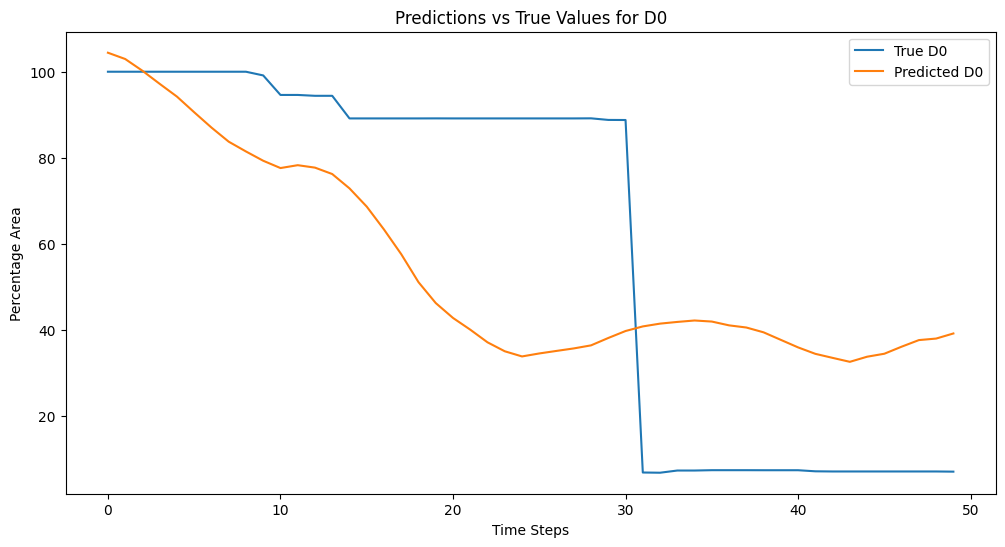

In [140]:
import matplotlib.pyplot as plt

# Plot predictions vs true values for D0 category as an example
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig[:, 0], label='True D0')
plt.plot(y_pred[:, 0], label='Predicted D0')
plt.title('Predictions vs True Values for D0')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Area')
plt.legend()
plt.show()


In [141]:
from sklearn.ensemble import RandomForestRegressor

# Flatten sequences for Random Forest (reshape to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_flat, y_train)

# Predict and evaluate RF model
rf_pred = rf_model.predict(X_test_flat)
rf_mae = mean_absolute_error(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae:.4f}")


Random Forest MAE: 0.1039


Accuracy: 0.9000
Confusion Matrix:
 [[45  5]
 [ 0  0]]


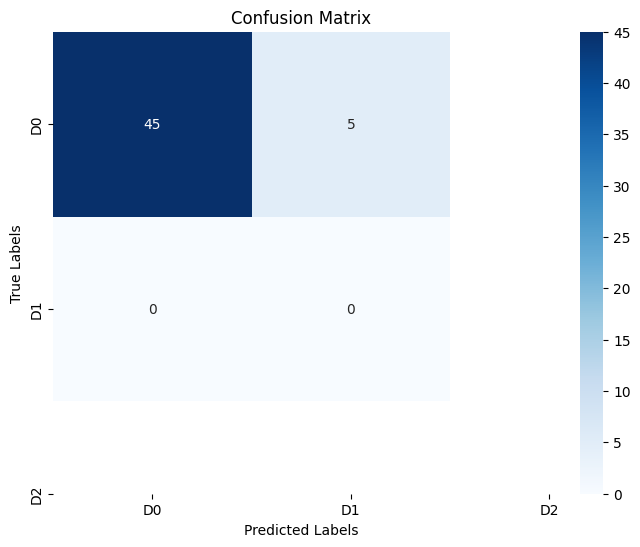

In [142]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Convert predictions and true values to categorical labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['D0', 'D1', 'D2'], yticklabels=['D0', 'D1', 'D2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Accuracy is variable. Goes form 0.74 to 0.9. Should do multiple runs of model? And should make model more robust. Maybe more data.

this is more classification --> change to prediction. Given this time period, predict the next week?

take weather, precipitation, and  --> datasets that give data on future date's climate

Do this after getting data --> causality with DoWhy --> codes up DAG

find the years that may have bad droughts/worst drought conditions

dew point (single value) if we're measuring one day (random day i.e. Jan 1st, 2066)
dew point if we have the previous week --> predict the next week (base off of trend/variability of temp, precip, dew point, humidity)

groundwater data for san bernardino

extract ppt, dp, etc. from tif file (maybe didn't do in the first run? -- find out)

Groundwater data -- combine dates from different well sites to get aggregate groundwater data per unique day.

In [5]:
# Load CSV data
df = pd.read_csv("SB_groundwater.csv", parse_dates=['datetime'])

# 1. Clean data: Ensure numeric values and filter provisional data (optional)
df['parameter_value'] = pd.to_numeric(df['parameter_value'], errors='coerce')
# df = df[df['qualification_cd'] == 'A']  # Uncomment to use only approved data

# 2. Group by date and sum parameter values
daily_totals = df.groupby('datetime', as_index=False).agg({
    'parameter_value': 'sum',
    'agency_cd': 'first'  # Assumes all rows are USGS
})

# 3. Rename columns and handle missing data
daily_totals = daily_totals.rename(columns={
    'parameter_value': 'total_parameter_value'
}).fillna(0)

# 4. Save consolidated data
daily_totals.to_csv("daily_groundwater_totals.csv", index=False)

print(daily_totals.head())

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_57915/1205911318.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("SB_groundwater.csv", parse_dates=['datetime'])


    datetime  total_parameter_value agency_cd
0 2000-01-01              638157.71      USGS
1 2000-01-02              637681.42      USGS
2 2000-01-03              634953.66      USGS
3 2000-01-04              634403.38      USGS
4 2000-01-05              637111.66      USGS


label droughts by type (flash drought for times when we go from D0 to Dk in a short period of time)

prism data format explanation: https://prism.oregonstate.edu/formats/

### Drought data labels by month

In [ ]:
# convert drought_df['DATE'] row to datetime format
drought_df['date'] = pd.to_datetime(drought_df['date'])
print(drought_df.head())

# group data by month and get most frequent value per month
drought_monthlydf = drought_df.groupby(drought_df['date'].dt.to_period('M'))[['D0', 'D1', 'D2', 'D3', 'D4']].mean().reset_index()

# drought_monthlydf.columns = ['date', 'D0', 'D1', 'D2', 'D3', 'D4']
print(drought_monthlydf.head())


          date    D0    D1    D2    D3    D4
660 1950-01-01  90.1  83.9  57.9  40.8  16.1
661 1950-02-01  92.7  89.4  72.4  50.8  13.1
662 1950-03-01  95.8  90.4  68.8  48.5   8.3
663 1950-04-01  96.1  90.9  70.6  43.6   0.2
664 1950-05-01  97.5  90.8  76.8  29.2   0.1
      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1


In [15]:
# convert to csv file
drought_monthlydf.to_csv("SB_monthly_drought_labels.csv", index=False)

### Get 1950-2013 observed historical data from livneh_vic and combine with predicted values from loca_vic HadGEM2-ES with rcp 8.5 to assume worst case baseline for carbon emissions for 2014-2024
different model information: 
1. HadGEM2-ES (warm/dry)
2. CanESM2 (average)
3. CNRM-CM5 (cooler/wetter)
4. MIROC5 the model least like the others to improve coverage of the range of outcomes

Change historical 1950-2013 data from daily to monthly to converge with loca-vic predictive data

In [67]:
# change daily to monthly
daily_airtemp2013 = pd.read_csv(path + '/data/livneh_vic/airtemp_daily.csv')
daily_baseflow2013 = pd.read_csv(path + '/data/livneh_vic/baseflow_daily.csv')
daily_ev2013 = pd.read_csv(path + '/data/livneh_vic/evapotranspiration_daily.csv')
daily_rainfall2013 = pd.read_csv(path + '/data/livneh_vic/rainfall_daily.csv')
daily_runoff2013 = pd.read_csv(path + '/data/livneh_vic/runoff_daily.csv')
daily_snowfall2013 = pd.read_csv(path + '/data/livneh_vic/snowfall_daily.csv')
daily_snowwater2013 = pd.read_csv(path + '/data/livneh_vic/snowwater_daily.csv')
daily_sm2013 = pd.read_csv(path + '/data/livneh_vic/soilmoisture_daily.csv')

dailydf = {"airtemp": daily_airtemp2013, 
           "baseflow": daily_baseflow2013, 
           "ev": daily_ev2013, 
           "rainfall": daily_rainfall2013, 
           "runoff": daily_runoff2013, 
           "snowfall": daily_snowfall2013, 
           "snowwater": daily_snowwater2013,
           "sm": daily_sm2013}

monthly2013_df = {}

for var, df in dailydf.items():
    df['date'] = pd.to_datetime(df['time'])
    column = df.columns[1]
    new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
    new_df.rename(columns={column: var}, inplace=True)
    # print(new_df.head())

    monthly2013_df[f"monthly_{var}2013"] = new_df

monthly_airtemp2013 = monthly2013_df['monthly_airtemp2013']
monthly_baseflow2013 = monthly2013_df['monthly_baseflow2013']
monthly_ev2013 = monthly2013_df['monthly_ev2013']
monthly_rainfall2013 = monthly2013_df['monthly_rainfall2013']
monthly_runoff2013 = monthly2013_df['monthly_runoff2013']
monthly_sm2013 = monthly2013_df['monthly_sm2013']
monthly_snowfall2013 = monthly2013_df['monthly_snowfall2013']
monthly_snowwater2013 = monthly2013_df['monthly_snowwater2013']

/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].mean().reset_index()
/var/folders/h6/vygxj7rj5tq9z54ggx6zd6080000gn/T/ipykernel_8990/1019791965.py:25: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  new_df = df.groupby(df['date'].dt.to_period('M'))[column].m

load loca-vic data and merge with the 1950-2013 dataa

In [ ]:
# load loca-vic rcp 8.5 data for all variables
# sample folder name that has projected values: projected_baseflow_2006_2099_monthly
# sample file name: tair_month_HadGEM2-ES_rcp85.csv

model = "HadGEM2-ES"
emissions = "rcp85"
monthlydf_names = ["airtemp", "baseflow", "ev", "rainfall", "runoff", "snowfall", "snowwater", "sm"]

monthly2024_df = {}
for t in monthlydf_names:
    new_df = pd.read_csv(path + f'/data/projected_{t}_2006_2099_monthly/{t}_month_{model}_{emissions}.csv')
    column = new_df.columns[1]
    new_df.rename(columns={column: t}, inplace=True)

    new_df.rename(columns={'time': 'date'}, inplace=True)
    
    # convert date column to datetime format
    new_df['date'] = pd.to_datetime(new_df['date'])
    # format the datetime objects to 'yyyy-mm'
    new_df['date'] = new_df['date'].dt.strftime('%Y-%m')

    monthly2024_df[f"monthly_{t}2024"] = new_df

monthly_airtemp2024 = monthly2024_df['monthly_airtemp2024']
monthly_baseflow2024 = monthly2024_df['monthly_baseflow2024']
monthly_ev2024 = monthly2024_df['monthly_ev2024']
monthly_rainfall2024 = monthly2024_df['monthly_rainfall2024']
monthly_runoff2024 = monthly2024_df['monthly_runoff2024']
monthly_sm2024 = monthly2024_df['monthly_sm2024']
monthly_snowfall2024 = monthly2024_df['monthly_snowfall2024']
monthly_snowwater2024 = monthly2024_df['monthly_snowwater2024']

In [85]:
# merge with monthly_{var_type}2013

airtemp_df = pd.concat([monthly_airtemp2013, monthly_airtemp2024], axis=0)
baseflow_df = pd.concat([monthly_baseflow2013, monthly_baseflow2024], axis=0)
ev_df = pd.concat([monthly_ev2013, monthly_ev2024], axis=0)
rainfall_df = pd.concat([monthly_rainfall2013, monthly_rainfall2024], axis=0)
runoff_df = pd.concat([monthly_runoff2013, monthly_runoff2024], axis=0)
sm_df = pd.concat([monthly_sm2013, monthly_sm2024], axis=0)
snowfall_df = pd.concat([monthly_snowfall2013, monthly_snowfall2024], axis=0)
snowwater_df = pd.concat([monthly_snowwater2013, monthly_snowwater2024], axis=0)

print(airtemp_df.head())
print(baseflow_df.head())
print(ev_df.head())
print(rainfall_df.head())
print(runoff_df.head())
print(sm_df.head())
print(snowfall_df.head())
print(snowwater_df.head())

new_dir = path + '/data/historical_all'
os.makedirs(new_dir, exist_ok=True)

# make all df into csv files in new directory
new_filepath = os.path.join(new_dir, "airtemp.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(airtemp_df)

new_filepath = os.path.join(new_dir, "baseflow.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(baseflow_df)

new_filepath = os.path.join(new_dir, "ev.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(ev_df)

new_filepath = os.path.join(new_dir, "rainfall.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(rainfall_df)

new_filepath = os.path.join(new_dir, "runoff.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(runoff_df)

new_filepath = os.path.join(new_dir, "sm.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(sm_df)

new_filepath = os.path.join(new_dir, "snowfall.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(snowfall_df)

new_filepath = os.path.join(new_dir, "snowwater.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(snowwater_df)

      date    airtemp
0  1950-01   5.469246
1  1950-02  11.261756
2  1950-03  13.522296
3  1950-04  18.837398
4  1950-05  20.676498
      date  baseflow
0  1950-01  0.036113
1  1950-02  0.036952
2  1950-03  0.033402
3  1950-04  0.039273
4  1950-05  0.029522
      date        ev
0  1950-01  0.712696
1  1950-02  0.947727
2  1950-03  0.763165
3  1950-04  0.317350
4  1950-05  0.155867
      date  rainfall
0  1950-01  0.207599
1  1950-02  0.446101
2  1950-03  0.412884
3  1950-04  0.112882
4  1950-05  0.021634
      date    runoff
0  1950-01  0.011982
1  1950-02  0.028984
2  1950-03  0.010870
3  1950-04  0.007152
4  1950-05  0.000562
      date         sm
0  1950-01  11.695956
1  1950-02   9.503363
2  1950-03   7.893302
3  1950-04   6.434203
4  1950-05   5.557502
      date  snowfall
0  1950-01  0.139311
1  1950-02  0.023380
2  1950-03  0.025884
3  1950-04  0.027177
4  1950-05  0.002887
      date  snowwater
0  1950-01   0.707678
1  1950-02   0.467992
2  1950-03   0.215861
3  1950-04   0.110

Merge drought levels data with variable data

In [86]:
from functools import reduce

# merge all variables together into dataframe
dfs = [airtemp_df, baseflow_df, ev_df, rainfall_df, runoff_df, sm_df, snowfall_df, snowwater_df]
historical_all_df = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dfs)
print(historical_all_df.head())

new_filepath = os.path.join(new_dir, "all_historical.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(historical_all_df)

      date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0  1950-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1  1950-02  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2  1950-03  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3  1950-04  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4  1950-05  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   

   snowfall  snowwater  
0  0.139311   0.707678  
1  0.023380   0.467992  
2  0.025884   0.215861  
3  0.027177   0.110780  
4  0.002887   0.026390  


In [ ]:
print(drought_df.head())

drought_df['date'] = pd.to_datetime(drought_df['date'], format='%Y-%m')
historical_all_df['date'] = pd.to_datetime(historical_all_df['date'], format='%Y-%m')

# merge historical_all_df with drought_df
final_historical_df = pd.merge(historical_all_df, drought_df, on='date', how='inner')
print(final_historical_df.head())

      date    D0    D1    D2    D3    D4
0  1950-01  90.1  83.9  57.9  40.8  16.1
1  1950-02  92.7  89.4  72.4  50.8  13.1
2  1950-03  95.8  90.4  68.8  48.5   8.3
3  1950-04  96.1  90.9  70.6  43.6   0.2
4  1950-05  97.5  90.8  76.8  29.2   0.1
        date    airtemp  baseflow        ev  rainfall    runoff         sm  \
0 1950-01-01   5.469246  0.036113  0.712696  0.207599  0.011982  11.695956   
1 1950-02-01  11.261756  0.036952  0.947727  0.446101  0.028984   9.503363   
2 1950-03-01  13.522296  0.033402  0.763165  0.412884  0.010870   7.893302   
3 1950-04-01  18.837398  0.039273  0.317350  0.112882  0.007152   6.434203   
4 1950-05-01  20.676498  0.029522  0.155867  0.021634  0.000562   5.557502   

   snowfall  snowwater    D0    D1    D2    D3    D4  
0  0.139311   0.707678  90.1  83.9  57.9  40.8  16.1  
1  0.023380   0.467992  92.7  89.4  72.4  50.8  13.1  
2  0.025884   0.215861  95.8  90.4  68.8  48.5   8.3  
3  0.027177   0.110780  96.1  90.9  70.6  43.6   0.2  
4  0.00288

In [ ]:
# make all df into csv files in new directory
new_filepath = os.path.join(new_dir, "final_historical.csv")
with open(new_filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(final_historical_df)

In [114]:
final_historical_df.to_csv("final_historical.csv")

#### Train MultiOutputRegressor(RandomForestRegressor())

🌲 Random Forest Performance:
D0: MSE = 2852.4957, R² = -0.6592
D1: MSE = 2702.5362, R² = -0.3998
D2: MSE = 1868.2296, R² = -0.3088
D3: MSE = 768.0249, R² = -0.0632
D4: MSE = 21.0144, R² = -2.1366
Overall pseudo-accuracy (1 - normalized MSE): -0.7135

⚡ XGBoost Performance:
D0: MSE = 2886.3962, R² = -0.6789
D1: MSE = 2685.4702, R² = -0.3910
D2: MSE = 1894.8922, R² = -0.3275
D3: MSE = 795.9202, R² = -0.1018
D4: MSE = 27.5035, R² = -3.1051
Overall pseudo-accuracy (1 - normalized MSE): -0.9209



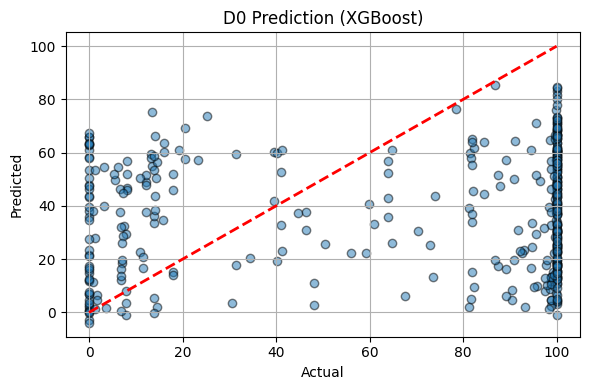

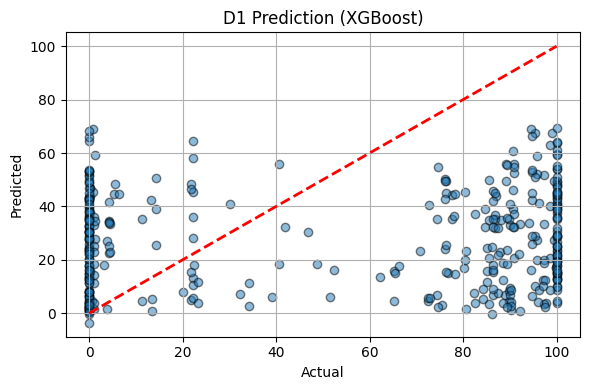

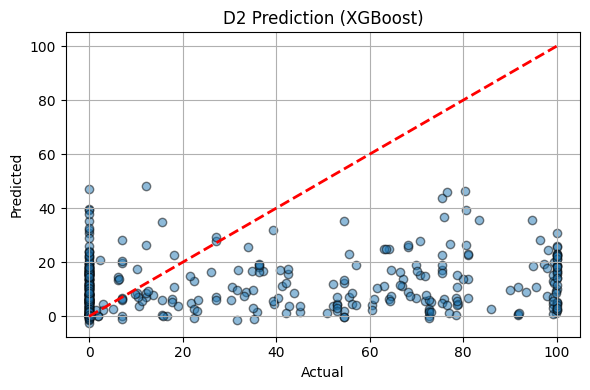

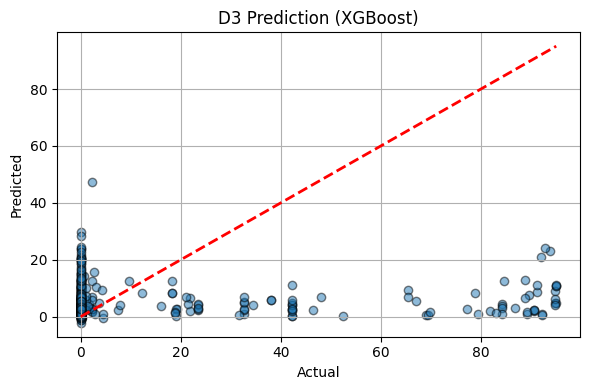

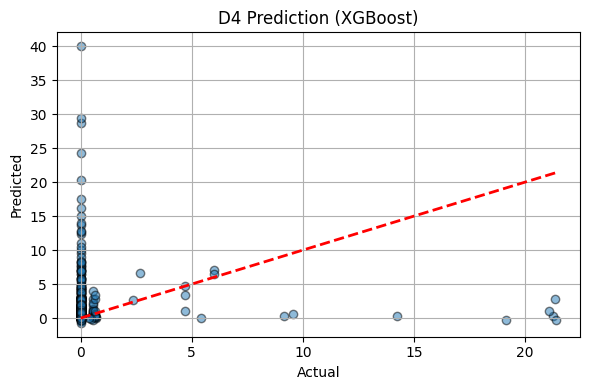

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# Load and prepare data
# df = pd.read_csv("final_historical.csv")
df = final_historical_df
df = df.dropna()

# Convert 'date' column to datetime if not already
df['date'] = pd.to_datetime(df['date'])

input_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']

# Step 1: Simplify Lagged Features (Keep only 1 lag feature for each input column)
for col in input_cols:
    df[f'{col}_lag1'] = df[col].shift(1)  # 1-month lag

# Drop rows with missing values created by lagging
df = df.dropna()

# Step 2: Create Time-Aware Train/Test Split (based on date)
X_train = df[df['date'] < '2000-01-01'][input_cols + [f'{col}_lag1' for col in input_cols]]
y_train = df[df['date'] < '2000-01-01'][target_cols]
X_test = df[df['date'] >= '2000-01-01'][input_cols + [f'{col}_lag1' for col in input_cols]]
y_test = df[df['date'] >= '2000-01-01'][target_cols]

# Step 3: Scale the Features (Input columns + lagged features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1️⃣ RANDOM FOREST MODEL
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42))
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

# Save model
joblib.dump(rf_model, "random_forest_drought.pkl")

# Evaluation
rf_mse = mean_squared_error(y_test, rf_pred, multioutput='raw_values')
rf_r2 = r2_score(y_test, rf_pred, multioutput='raw_values')
rf_accuracy = 1 - np.mean(rf_mse / np.var(y_test, axis=0))

print("🌲 Random Forest Performance:")
for i, col in enumerate(target_cols):
    print(f"{col}: MSE = {rf_mse[i]:.4f}, R² = {rf_r2[i]:.4f}")
print(f"Overall pseudo-accuracy (1 - normalized MSE): {rf_accuracy:.4f}\n")


# 2️⃣ XGBOOST MODEL
xgb_model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=4, verbosity=0))
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

# Save model
joblib.dump(xgb_model, "xgboost_drought.pkl")

# Evaluation
xgb_mse = mean_squared_error(y_test, xgb_pred, multioutput='raw_values')
xgb_r2 = r2_score(y_test, xgb_pred, multioutput='raw_values')
xgb_accuracy = 1 - np.mean(xgb_mse / np.var(y_test, axis=0))

print("⚡ XGBoost Performance:")
for i, col in enumerate(target_cols):
    print(f"{col}: MSE = {xgb_mse[i]:.4f}, R² = {xgb_r2[i]:.4f}")
print(f"Overall pseudo-accuracy (1 - normalized MSE): {xgb_accuracy:.4f}\n")


# 🔍 Visualization (XGBoost)
for i, col in enumerate(target_cols):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test[col], xgb_pred[:, i], alpha=0.5, edgecolor='k')
    plt.plot([y_test[col].min(), y_test[col].max()],
             [y_test[col].min(), y_test[col].max()],
             'r--', lw=2)
    plt.title(f"{col} Prediction (XGBoost)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1316.2039 - val_loss: 2711.0486
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1189.3478 - val_loss: 2360.4976
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 987.7020 - val_loss: 2006.6566
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 840.2629 - val_loss: 1690.6729
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 703.4045 - val_loss: 1419.1241
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 642.2027 - val_loss: 1189.3143
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 562.9160 - val_loss: 1065.3083
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 513.8745 - val_loss: 1073.3639
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 463.1053 - val_loss: 1064.6371
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 385.7113 - val_loss: 953.3474
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 392.9638 - val_loss: 1390.9585
Epoch 12/100
23/23

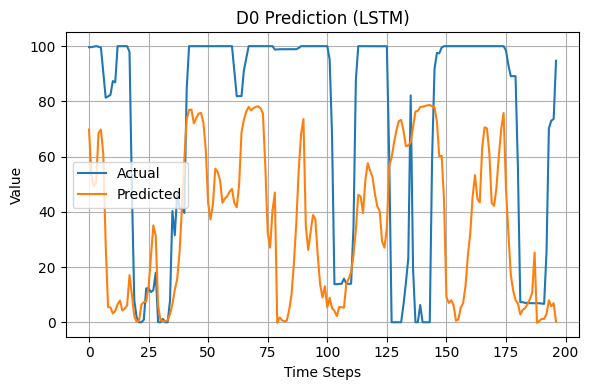

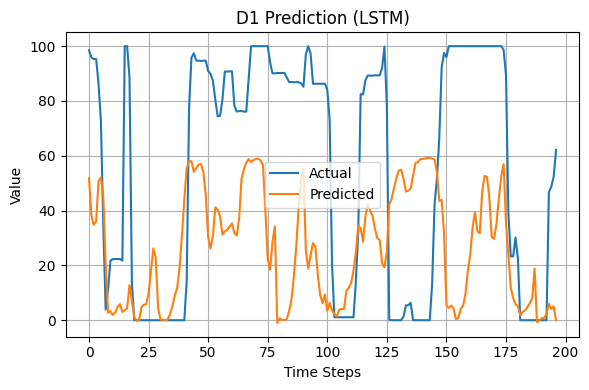

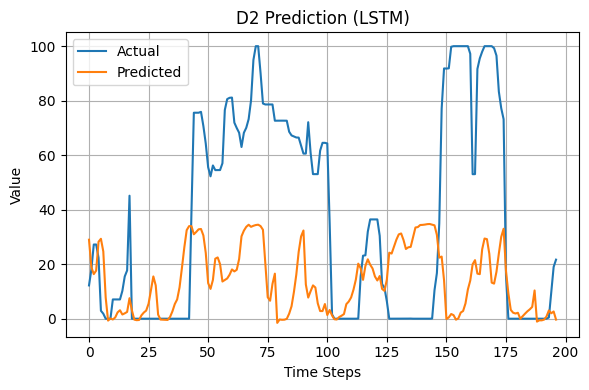

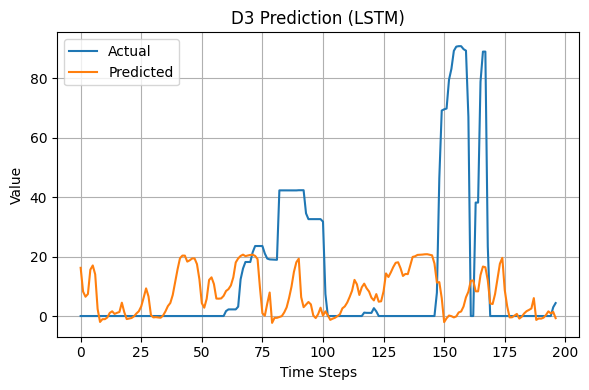

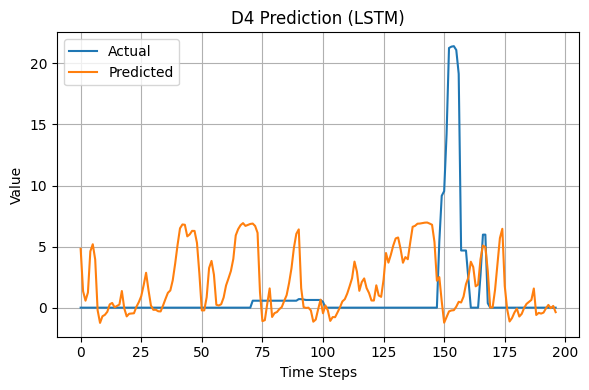

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- LOAD & PREP DATA ---
# df = pd.read_csv("final_historical.csv")
df = final_historical_df
df['date'] = pd.to_datetime(df['date'])
df = df.dropna()

input_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']

# --- SCALE FEATURES ---
scaler = StandardScaler()
df[input_cols] = scaler.fit_transform(df[input_cols])

# --- CREATE SEQUENCES ---
def create_sequences(df, input_cols, target_cols, seq_len=12):
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(df[input_cols].iloc[i:i+seq_len].values)
        y.append(df[target_cols].iloc[i+seq_len].values)  # predict drought at next time step
    return np.array(X), np.array(y)

SEQ_LEN = 12
X_seq, y_seq = create_sequences(df, input_cols, target_cols, SEQ_LEN)

# --- TIME-AWARE SPLIT ---
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# --- LSTM MODEL ---
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, len(input_cols)), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(len(target_cols))  # one output per drought class
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# --- TRAIN ---
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

# --- EVALUATE ---
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')
pseudo_acc = 1 - np.mean(mse / np.var(y_test, axis=0))

print("📉 LSTM Performance:")
for i, col in enumerate(target_cols):
    print(f"{col}: MSE = {mse[i]:.4f}, R² = {r2[i]:.4f}")
print(f"Overall pseudo-accuracy (1 - normalized MSE): {pseudo_acc:.4f}\n")

# --- PLOT PREDICTIONS ---
for i, col in enumerate(target_cols):
    plt.figure(figsize=(6, 4))
    plt.plot(y_test[:, i], label="Actual")
    plt.plot(y_pred[:, i], label="Predicted")
    plt.title(f"{col} Prediction (LSTM)")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6365 - val_loss: 0.5452 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5382 - val_loss: 0.4863 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4729 - val_loss: 0.4707 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4537 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4496 - val_loss: 0.4511 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4554 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4168 - val_loss: 0.4365 - learning_rate: 0.0010
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4456 - val_loss: 0.4311 - learning_rate: 0.0010
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4154 - val_loss: 0.4299 - learning_rate: 0.0010
Epoch 10/100
17/17 ━━━━━━━━━━━

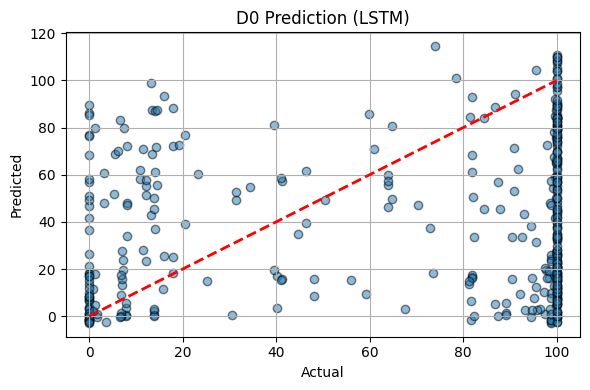

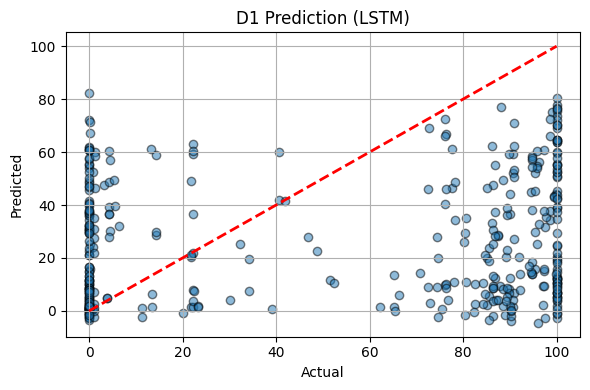

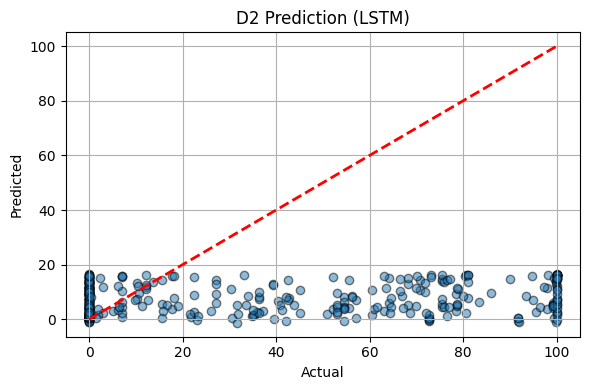

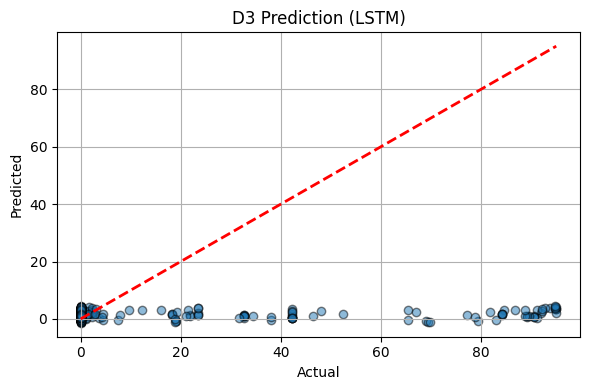

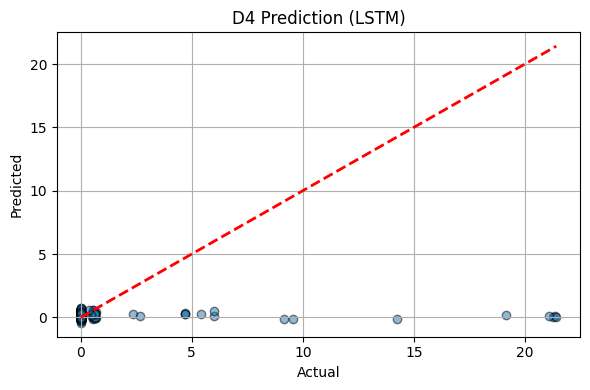

In [128]:
# === IMPORTS ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# === LOAD & PREPROCESS ===
# df = pd.read_csv("final_historical.csv")
df = final_historical_df
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])

input_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
SEQ_LEN = 3  # how many months of memory

# === SCALING ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()
df[input_cols] = scaler_X.fit_transform(df[input_cols])
df[target_cols] = scaler_y.fit_transform(df[target_cols])

# === CREATE SEQUENCES ===
def create_sequences(df, input_cols, target_cols, seq_len):
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(df[input_cols].iloc[i:i+seq_len].values)
        y.append(df[target_cols].iloc[i+seq_len].values)
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(df, input_cols, target_cols, SEQ_LEN)

# === TIME-AWARE SPLIT ===
dates = df['date'].iloc[SEQ_LEN:].reset_index(drop=True)
split_date = pd.Timestamp('2000-01-01')
train_idx = dates < split_date
test_idx = dates >= split_date

X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_test, y_test = X_seq[test_idx], y_seq[test_idx]

# === MODEL BUILDING ===
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, len(input_cols))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(target_cols))
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# === TRAINING ===
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# === PREDICTION & INVERSE SCALING ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# === EVALUATION ===
mse = mean_squared_error(y_test_inv, y_pred_inv, multioutput='raw_values')
r2 = r2_score(y_test_inv, y_pred_inv, multioutput='raw_values')
pseudo_acc = 1 - np.mean(mse / np.var(y_test_inv, axis=0))

print("📉 LSTM Performance:")
for i, col in enumerate(target_cols):
    print(f"{col}: MSE = {mse[i]:.4f}, R² = {r2[i]:.4f}")
print(f"Overall pseudo-accuracy (1 - normalized MSE): {pseudo_acc:.4f}")

# === PLOT RESULTS ===
for i, col in enumerate(target_cols):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_inv[:, i], y_pred_inv[:, i], alpha=0.5, edgecolor='k')
    plt.plot([y_test_inv[:, i].min(), y_test_inv[:, i].max()],
             [y_test_inv[:, i].min(), y_test_inv[:, i].max()],
             'r--', lw=2)
    plt.title(f"{col} Prediction (LSTM)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.7170 - val_loss: 0.4966 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5647 - val_loss: 0.4987 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5077 - val_loss: 0.4759 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4958 - val_loss: 0.4589 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4660 - val_loss: 0.4781 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4517 - val_loss: 0.4771 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4381 - val_loss: 0.4526 - learning_rate: 0.0010
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4409 - val_loss: 0.4548 - learning_rate: 0.0010
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4152 - val_loss: 0.4585 - learning_rate: 0.0010
Epoch 10/1

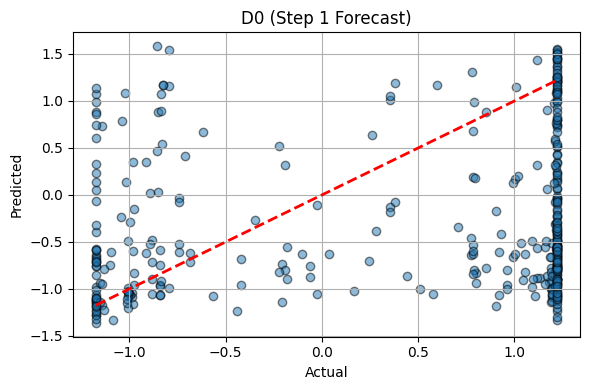

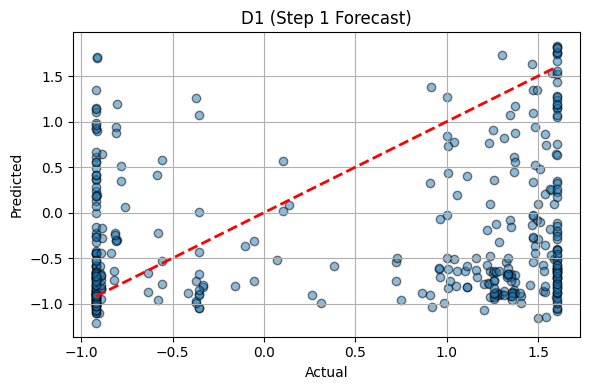

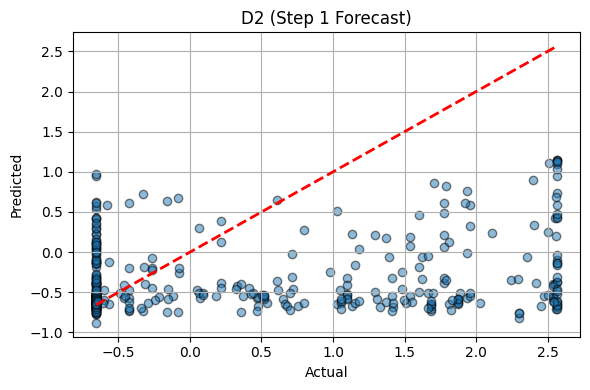

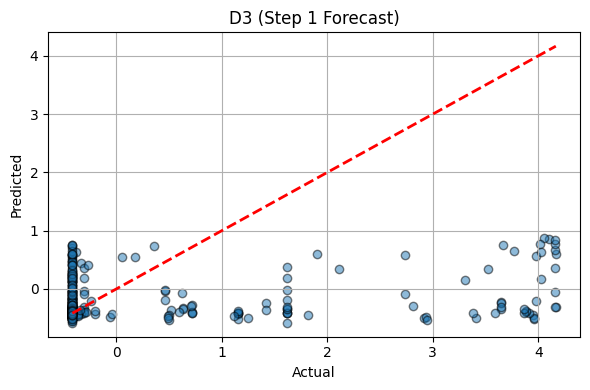

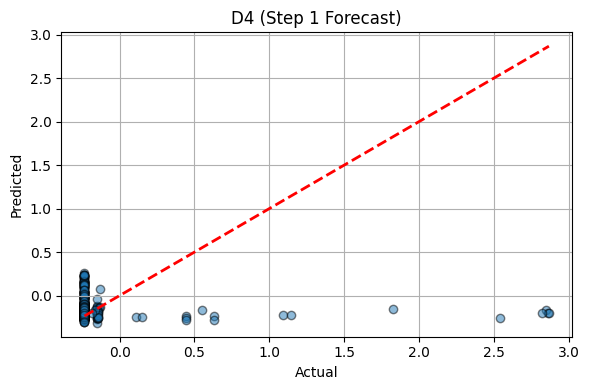

In [129]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Attention, LayerNormalization, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# === LOAD & CLEAN ===
# df = pd.read_csv("final_historical.csv")
df = final_historical_df
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])

input_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
SEQ_LEN = 6          # number of months to look back
PRED_HORIZON = 3     # number of future steps to predict

# === SCALE ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()
df[input_cols] = scaler_X.fit_transform(df[input_cols])
df[target_cols] = scaler_y.fit_transform(df[target_cols])

# === SEQUENCE CREATION ===
def create_multi_horizon_sequences(df, input_cols, target_cols, seq_len, pred_horizon):
    X, y = [], []
    for i in range(len(df) - seq_len - pred_horizon + 1):
        X.append(df[input_cols].iloc[i:i+seq_len].values)
        y.append(df[target_cols].iloc[i+seq_len:i+seq_len+pred_horizon].values)
    return np.array(X), np.array(y)

X_seq, y_seq = create_multi_horizon_sequences(df, input_cols, target_cols, SEQ_LEN, PRED_HORIZON)

# === TIME-AWARE SPLIT ===
dates = df['date'].iloc[SEQ_LEN:SEQ_LEN + len(y_seq)].reset_index(drop=True)
split_date = pd.Timestamp("2000-01-01")
train_idx = dates < split_date
test_idx = dates >= split_date

X_train, y_train = X_seq[train_idx], y_seq[train_idx]
X_test, y_test = X_seq[test_idx], y_seq[test_idx]

# === MODEL WITH ATTENTION ===
input_layer = Input(shape=(SEQ_LEN, len(input_cols)))
x = GRU(128, return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LayerNormalization()(x)

# Attention block
query = Dense(64)(x)
key = Dense(64)(x)
value = Dense(64)(x)
attn_out = Attention(use_scale=True)([query, value, key])
attn_out = LayerNormalization()(attn_out)

x = Concatenate()([x, attn_out])
x = GRU(64)(x)
x = Dropout(0.2)(x)
output = Dense(PRED_HORIZON * len(target_cols))(x)
output = tf.keras.layers.Reshape((PRED_HORIZON, len(target_cols)))(output)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=Adam(0.001), loss='mae')

# === TRAIN ===
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# === PREDICT & EVALUATE ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, len(target_cols))).reshape(-1, PRED_HORIZON, len(target_cols))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, len(target_cols))).reshape(-1, PRED_HORIZON, len(target_cols))

# Evaluate at each future time step
print("📉 Multi-Horizon GRU + Attention Performance:")
for step in range(PRED_HORIZON):
    mse = mean_squared_error(y_test_inv[:, step], y_pred_inv[:, step], multioutput='raw_values')
    r2 = r2_score(y_test_inv[:, step], y_pred_inv[:, step], multioutput='raw_values')
    pseudo_acc = 1 - np.mean(mse / np.var(y_test_inv[:, step], axis=0))
    print(f"🔮 Step {step+1}:")
    for i, col in enumerate(target_cols):
        print(f"  {col}: MSE = {mse[i]:.4f}, R² = {r2[i]:.4f}")
    print(f"  Overall pseudo-accuracy: {pseudo_acc:.4f}\n")

# === PLOTS ===
for i, col in enumerate(target_cols):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_inv[:, 0, i], y_pred_inv[:, 0, i], alpha=0.5, edgecolor='k')
    plt.plot([y_test_inv[:, 0, i].min(), y_test_inv[:, 0, i].max()],
             [y_test_inv[:, 0, i].min(), y_test_inv[:, 0, i].max()],
             'r--', lw=2)
    plt.title(f"{col} (Step 1 Forecast)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#### training independently for each drought label


🚀 Training for D0...

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.8686 - val_loss: 0.6568 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6119 - val_loss: 0.5831 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5615 - val_loss: 0.5117 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5269 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5084 - val_loss: 0.5733 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4914 - val_loss: 0.5693 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5170 - val_loss: 0.6140 - learning_rate: 0.0010
Epoch 8/100
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5099 
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5033 - val_loss: 0.54

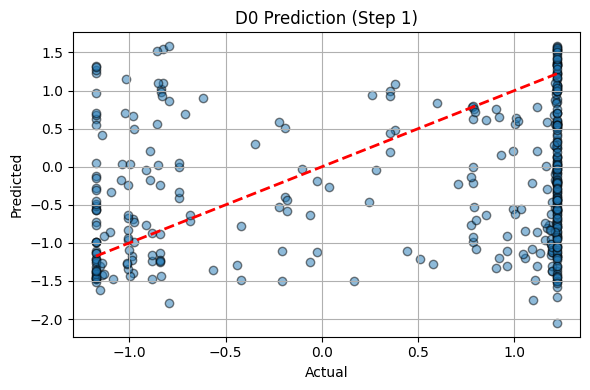


🚀 Training for D1...

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.7492 - val_loss: 0.6243 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5562 - val_loss: 0.5152 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5115 - val_loss: 0.5577 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5193 - val_loss: 0.5552 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4987 - val_loss: 0.5887 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4912 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 7/100
12/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4813 
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4742 - val_loss: 0.5620 - learning_rate: 0.0010
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4542 - val_loss: 0.56

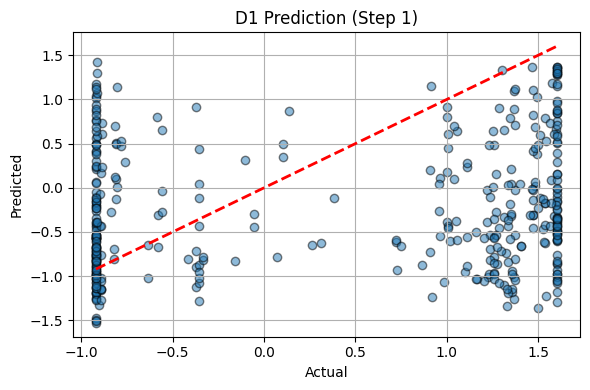


🚀 Training for D2...

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.6824 - val_loss: 0.5063 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5530 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5326 - val_loss: 0.4458 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5081 - val_loss: 0.4520 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4816 - val_loss: 0.4513 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4623 - val_loss: 0.4432 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4455 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4131 - val_loss: 0.4340 - learning_rate: 0.0010
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4204 - val_loss: 0.4198 - learning_rate: 

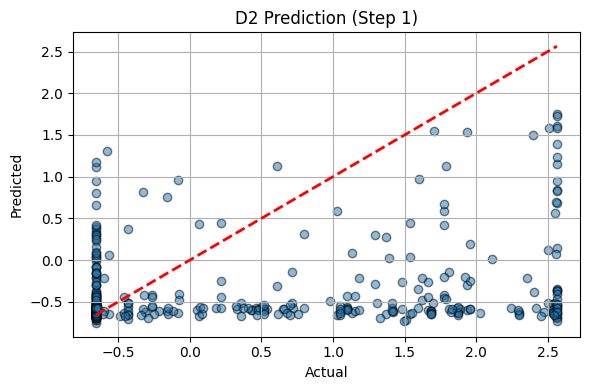


🚀 Training for D3...

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.7078 - val_loss: 0.4239 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5704 - val_loss: 0.4335 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5265 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4835 - val_loss: 0.3855 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4619 - val_loss: 0.3832 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4265 - val_loss: 0.3756 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4381 - val_loss: 0.3633 - learning_rate: 0.0010
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4475 - val_loss: 0.3743 - learning_rate: 0.0010
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4141 - val_loss: 0.3576 - learning_rate: 0.

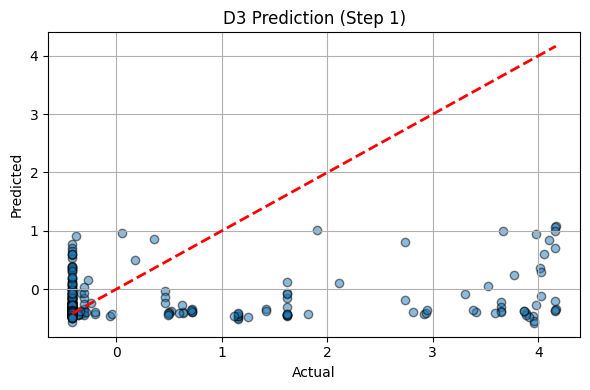


🚀 Training for D4...

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.7566 - val_loss: 0.5905 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6469 - val_loss: 0.5551 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5732 - val_loss: 0.5330 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5591 - val_loss: 0.4979 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5616 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5365 - val_loss: 0.5008 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5008 - val_loss: 0.4646 - learning_rate: 0.0010
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4819 - val_loss: 0.4957 - learning_rate: 0.0010
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4981 - val_loss: 0.4645 - learning_rate: 0.

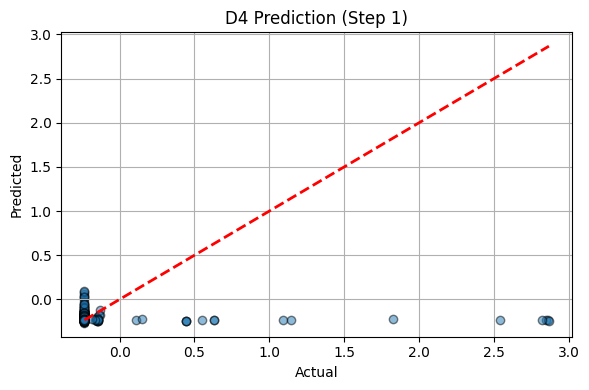

In [130]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Attention, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# === LOAD & CLEAN ===
# df = pd.read_csv("final_historical.csv")
df = final_historical_df
df.dropna(inplace=True)
df['date'] = pd.to_datetime(df['date'])

input_cols = ['airtemp', 'baseflow', 'ev', 'rainfall', 'runoff', 'sm', 'snowfall', 'snowwater']
target_cols = ['D0', 'D1', 'D2', 'D3', 'D4']
SEQ_LEN = 6
PRED_HORIZON = 3  # multi-horizon (e.g., next 3 months)

# === SCALE INPUT FEATURES ===
scaler_X = StandardScaler()
df[input_cols] = scaler_X.fit_transform(df[input_cols])

# === CREATE SEQUENCES FOR EACH TARGET ===
def create_sequences(df, input_cols, target_col, seq_len, pred_horizon):
    X, y = [], []
    for i in range(len(df) - seq_len - pred_horizon + 1):
        X.append(df[input_cols].iloc[i:i+seq_len].values)
        y.append(df[target_col].iloc[i+seq_len:i+seq_len+pred_horizon].values)
    return np.array(X), np.array(y)

# === TIME SPLIT HELPER ===
def time_aware_split(X, y, dates, split_date):
    split_mask = dates < split_date
    return X[split_mask], y[split_mask], X[~split_mask], y[~split_mask]

# === TRAIN EACH MODEL ===
for target_col in target_cols:
    print(f"\n🚀 Training for {target_col}...\n")
    
    # Scale the target independently
    scaler_y = StandardScaler()
    df[target_col] = scaler_y.fit_transform(df[[target_col]])
    
    X_seq, y_seq = create_sequences(df, input_cols, target_col, SEQ_LEN, PRED_HORIZON)
    dates = df['date'].iloc[SEQ_LEN:SEQ_LEN + len(y_seq)].reset_index(drop=True)
    
    X_train, y_train, X_test, y_test = time_aware_split(X_seq, y_seq, dates, pd.Timestamp("2000-01-01"))
    
    # === MODEL ===
    input_layer = Input(shape=(SEQ_LEN, len(input_cols)))
    x = GRU(64, return_sequences=True)(input_layer)
    x = Dropout(0.2)(x)
    x = LayerNormalization()(x)

    # Attention layer
    query = Dense(32)(x)
    key = Dense(32)(x)
    value = Dense(32)(x)
    attn_out = Attention(use_scale=True)([query, value, key])
    x = tf.keras.layers.Concatenate()([x, attn_out])

    x = GRU(32)(x)
    x = Dropout(0.2)(x)
    output = Dense(PRED_HORIZON)(x)  # One output per month

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(0.001), loss='mae')

    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=32,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Predict + Inverse Scale
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    y_test_inv = scaler_y.inverse_transform(y_test)

    # === EVALUATION ===
    mse = mean_squared_error(y_test_inv, y_pred_inv, multioutput='raw_values')
    r2 = r2_score(y_test_inv, y_pred_inv, multioutput='raw_values')
    pseudo_acc = 1 - np.mean(mse / np.var(y_test_inv, axis=0))

    print(f"📉 {target_col} Performance:")
    for i in range(PRED_HORIZON):
        print(f"Step {i+1}: MSE = {mse[i]:.4f}, R² = {r2[i]:.4f}")
    print(f"Overall pseudo-accuracy: {pseudo_acc:.4f}")

    # === PLOT FIRST STEP ===
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_inv[:, 0], y_pred_inv[:, 0], alpha=0.5, edgecolor='k')
    plt.plot([y_test_inv[:, 0].min(), y_test_inv[:, 0].max()],
             [y_test_inv[:, 0].min(), y_test_inv[:, 0].max()],
             'r--', lw=2)
    plt.title(f"{target_col} Prediction (Step 1)")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Old LSTM Model

In [133]:
print(final_historical_df.head())

        date   airtemp  baseflow        ev  rainfall    runoff        sm  \
0 1950-01-01 -1.672765 -0.178299  1.037903 -0.352457 -0.204852  0.943884   
1 1950-02-01 -0.932700 -0.163561  1.767875  0.048854  0.074557  0.320340   
2 1950-03-01 -0.643887 -0.225934  1.194652 -0.007038 -0.223122 -0.137539   
3 1950-04-01  0.035183 -0.122768 -0.189989 -0.511831 -0.284229 -0.552486   
4 1950-05-01  0.270151 -0.294117 -0.691535 -0.665367 -0.392526 -0.801808   

   snowfall  snowwater        D0        D1        D2        D3        D4  
0  1.538205  -0.057486  0.983769  1.196549  1.208339  1.548997  2.098084  
1 -0.136239  -0.196206  1.046040  1.335328  1.675393  2.031186  1.663477  
2 -0.100080  -0.342129  1.120286  1.360561  1.559435  1.920283  0.968106  
3 -0.081406  -0.402945  1.127472  1.373177  1.617414  1.684010 -0.205334  
4 -0.432241  -0.451787  1.161002  1.370654  1.817120  0.989658 -0.219821  


In [135]:
# Select features and target
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]  # Multi-output regression

# Ensure proper data preparation
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Check if required columns exist
required_cols = ['date', 'D0', 'D1', 'D2', 'D3', 'D4']
missing_cols = [col for col in required_cols if col not in final_historical_df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in final_df: {missing_cols}")

# Add temporal features
pd.to_datetime(final_historical_df['date'])

# final_historical_df['date'] = final_historical_df['date'][:-2]

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

print(f"Features shape: {X_scaled.shape}, Target shape: {y_scaled.shape}")

Features shape: (996, 8), Target shape: (996, 5)


In [136]:
# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])  # Predict next step after sequence
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 12  # Lookback period (12 weeks)
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

print(f"Sequence shapes - X_seq: {X_seq.shape}, y_seq: {y_seq.shape}")

Sequence shapes - X_seq: (984, 12, 8), y_seq: (984, 5)


In [137]:
# Split sequences into train and test sets
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(f"Train shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

Train shapes - X_train: (787, 12, 8), y_train: (787, 5)
Test shapes - X_test: (197, 12, 8), y_test: (197, 5)


In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)  # Output size matches the number of drought categories (D0-D4)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1236 - mae: 0.2292 - val_loss: 0.1614 - val_mae: 0.2948
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0897 - mae: 0.2141 - val_loss: 0.1446 - val_mae: 0.2839
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0722 - mae: 0.1910 - val_loss: 0.1341 - val_mae: 0.2719
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0681 - mae: 0.1843 - val_loss: 0.1424 - val_mae: 0.2767
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0647 - mae: 0.1820 - val_loss: 0.1349 - val_mae: 0.2626
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0545 - mae: 0.1631 - val_loss: 0.1324 - val_mae: 0.2627
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0561 - mae: 0.1682 - val_loss: 0.1556 - val_mae: 0.2779
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0530 - mae: 0.1619 - val_loss: 0.1600 - val_mae: 0.2781
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0487 - mae: 0.

In [139]:
# Make predictions on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

print(f"Prediction shape: {y_pred.shape}, True labels shape: {y_test_orig.shape}")

# Evaluate using MAE for each drought category (D0-D4)
from sklearn.metrics import mean_absolute_error

for i, category in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred[:, i])
    print(f"MAE for {category}: {mae:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction shape: (197, 5), True labels shape: (197, 5)
MAE for D0: 0.8740
MAE for D1: 0.9487
MAE for D2: 1.0098
MAE for D3: 0.9931
MAE for D4: 0.3966


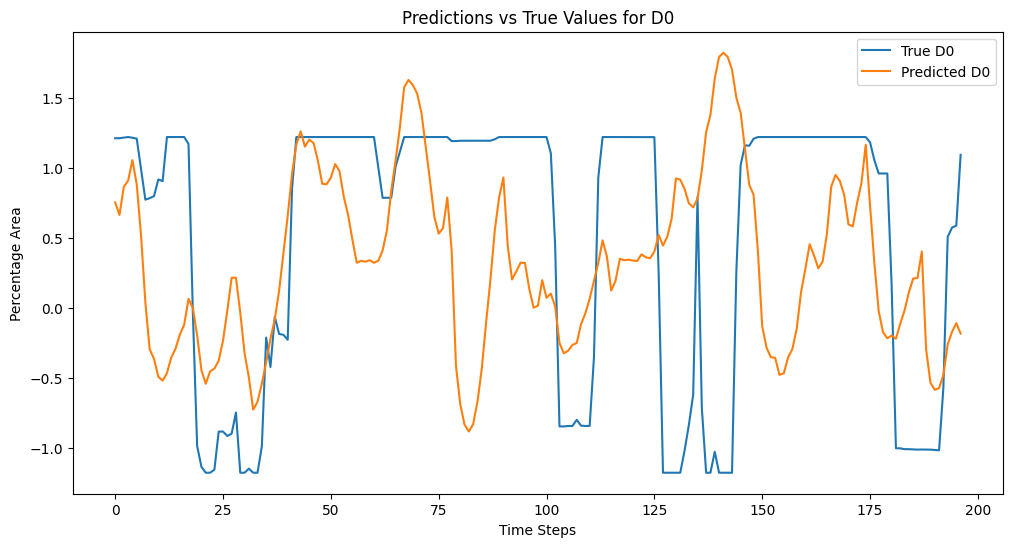

In [140]:
import matplotlib.pyplot as plt

# Plot predictions vs true values for D0 category as an example
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig[:, 0], label='True D0')
plt.plot(y_pred[:, 0], label='Predicted D0')
plt.title('Predictions vs True Values for D0')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Area')
plt.legend()
plt.show()

In [141]:
from sklearn.ensemble import RandomForestRegressor

# Flatten sequences for Random Forest (reshape to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_flat, y_train)

# Predict and evaluate RF model
rf_pred = rf_model.predict(X_test_flat)
rf_mae = mean_absolute_error(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae:.4f}")

Random Forest MAE: 0.2742


Accuracy: 0.3249
Confusion Matrix:
 [[63  7 14 13 66]
 [18  1  2  2 11]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


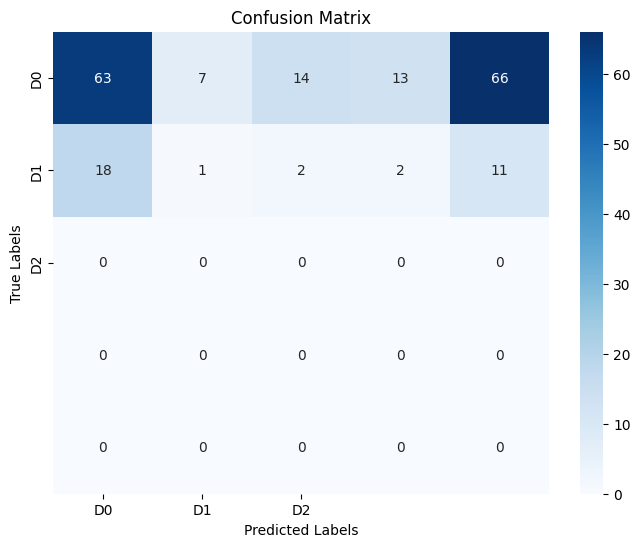

In [142]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Convert predictions and true values to categorical labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['D0', 'D1', 'D2'], yticklabels=['D0', 'D1', 'D2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Select features and target
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]  # Multi-output regression

# Ensure proper data preparation
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Check if required columns exist
required_cols = ['date', 'D0', 'D1', 'D2', 'D3', 'D4']
missing_cols = [col for col in required_cols if col not in final_historical_df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in final_df: {missing_cols}")

# Add temporal features
pd.to_datetime(final_historical_df['date'])

# final_historical_df['date'] = final_historical_df['date'][:-2]

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

print(f"Features shape: {X_scaled.shape}, Target shape: {y_scaled.shape}")

# Create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])  # Predict next step after sequence
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 12  # Lookback period (12 weeks)
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

print(f"Sequence shapes - X_seq: {X_seq.shape}, y_seq: {y_seq.shape}")

# Split sequences into train and test sets
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(f"Train shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test shapes - X_test: {X_test.shape}, y_test: {y_test.shape}")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)  # Output size matches the number of drought categories (D0-D4)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Make predictions on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

print(f"Prediction shape: {y_pred.shape}, True labels shape: {y_test_orig.shape}")

# Evaluate using MAE for each drought category (D0-D4)
from sklearn.metrics import mean_absolute_error

for i, category in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred[:, i])
    print(f"MAE for {category}: {mae:.4f}")

import matplotlib.pyplot as plt

# Plot predictions vs true values for D0 category as an example
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig[:, 0], label='True D0')
plt.plot(y_pred[:, 0], label='Predicted D0')
plt.title('Predictions vs True Values for D0')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Area')
plt.legend()
plt.show()

from sklearn.ensemble import RandomForestRegressor

# Flatten sequences for Random Forest (reshape to 2D)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_flat, y_train)

# Predict and evaluate RF model
rf_pred = rf_model.predict(X_test_flat)
rf_mae = mean_absolute_error(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae:.4f}")

from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Convert predictions and true values to categorical labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("Confusion Matrix:\n", conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['D0', 'D1', 'D2'], yticklabels=['D0', 'D1', 'D2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


🚀 Training model for D0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
D0 MAE: 0.9132, MSE: 1.1864, R²: -0.2771


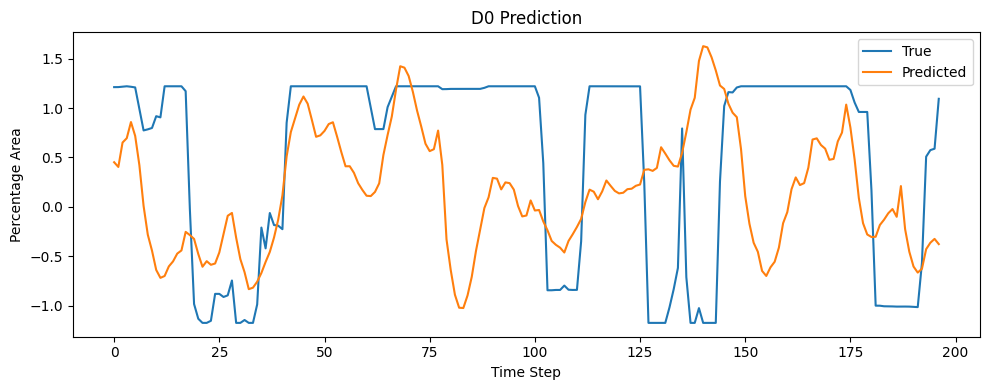

🌳 Random Forest D0 MAE: 1.0531, R²: -0.5226

🚀 Training model for D1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
D1 MAE: 1.0066, MSE: 1.3339, R²: -0.1479


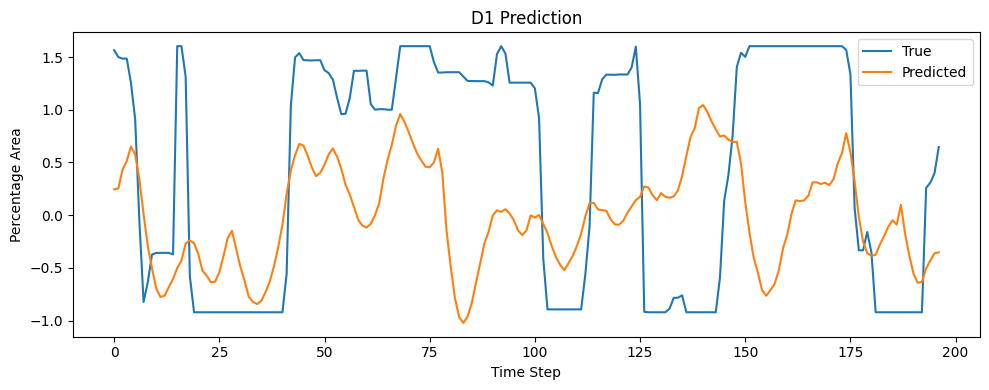

🌳 Random Forest D1 MAE: 1.0503, R²: -0.2609

🚀 Training model for D2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
D2 MAE: 1.0554, MSE: 1.6514, R²: -0.1441


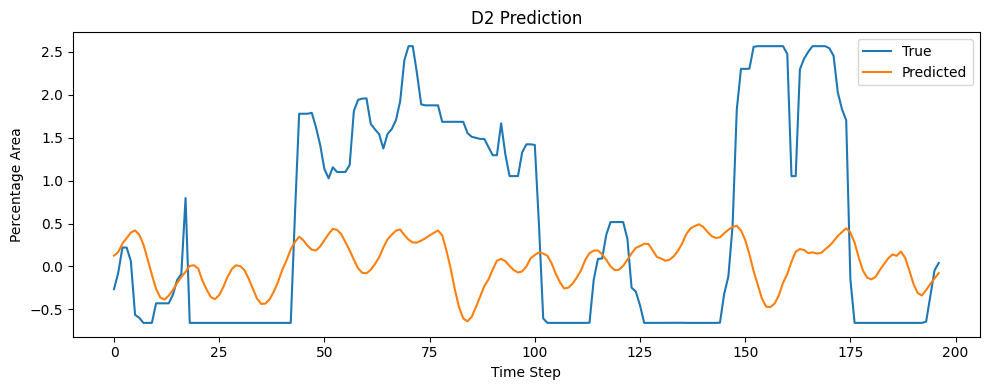

🌳 Random Forest D2 MAE: 1.0563, R²: -0.2491

🚀 Training model for D3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
D3 MAE: 0.8042, MSE: 1.5089, R²: -0.1385


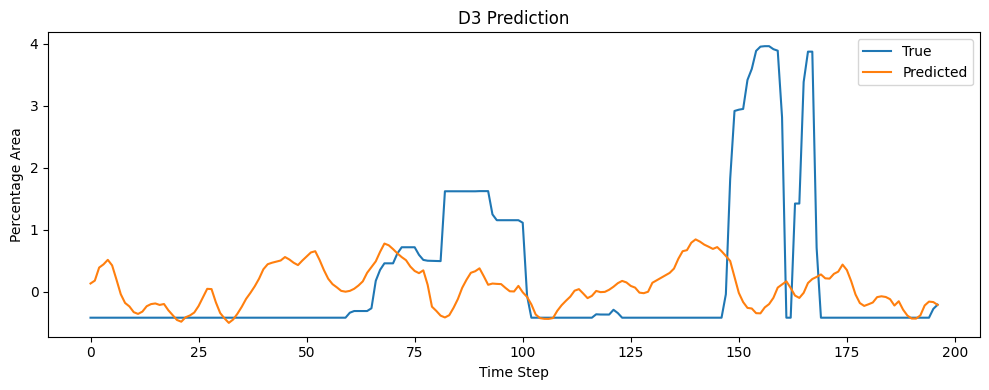

🌳 Random Forest D3 MAE: 0.7305, R²: -0.0713

🚀 Training model for D4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
D4 MAE: 0.3781, MSE: 0.3687, R²: -0.3522


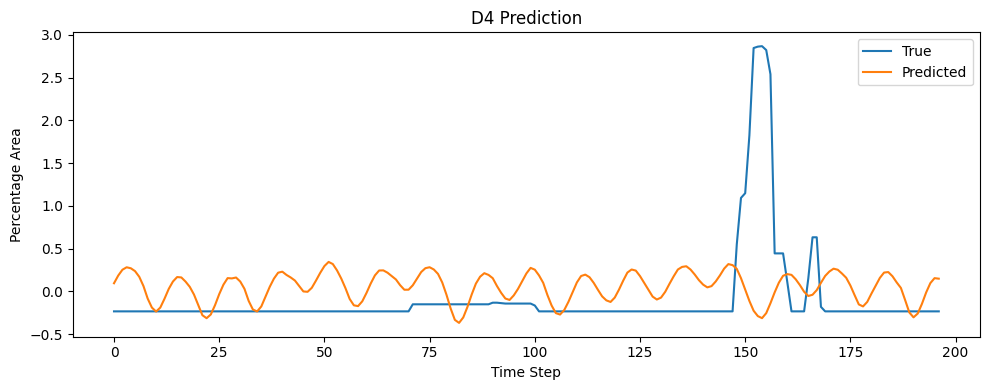

🌳 Random Forest D4 MAE: 0.2750, R²: -0.2587


In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor

# Setup
SEQ_LENGTH = 12
categories = ['D0', 'D1', 'D2', 'D3', 'D4']
results = {}

# Convert date column
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Feature matrix (constant across models)
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(features)

# Sequence creation function
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Loop over drought categories
for cat in categories:
    print(f"\n🚀 Training model for {cat}")

    # Prepare target
    y = final_historical_df[[cat]].values
    target_scaler = MinMaxScaler()
    y_scaled = target_scaler.fit_transform(y)

    # Create sequences
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

    # Train-test split
    split_idx = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    # Build LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
        Dropout(0.3),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )

    # Predict
    y_pred_scaled = model.predict(X_test)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_test_orig = target_scaler.inverse_transform(y_test)

    # Metrics
    mae = mean_absolute_error(y_test_orig, y_pred)
    mse = mean_squared_error(y_test_orig, y_pred)
    r2 = r2_score(y_test_orig, y_pred)

    print(f"{cat} MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

    # Save results
    results[cat] = {
        'true': y_test_orig.flatten(),
        'pred': y_pred.flatten(),
        'mae': mae,
        'mse': mse,
        'r2': r2
    }

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'{cat} Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Percentage Area')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional: Random Forest comparison
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X_train_flat, y_train.ravel())
    rf_pred = target_scaler.inverse_transform(rf.predict(X_test_flat).reshape(-1, 1))

    rf_mae = mean_absolute_error(y_test_orig, rf_pred)
    rf_r2 = r2_score(y_test_orig, rf_pred)

    print(f"🌳 Random Forest {cat} MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")


In [145]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd

# Replace this with your actual dataframe
# final_historical_df = pd.read_csv('your_data.csv')

# Drop any rows with missing values
final_historical_df = final_historical_df.dropna()

# Features to use
X_raw = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])

# Store results
metrics = {}

# Train a separate model for each drought level
for target_col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    print(f"\nTraining model for {target_col}...")

    # Target column
    y_raw = final_historical_df[target_col].values.reshape(-1, 1)

    # Scale features and target
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X = X_scaler.fit_transform(X_raw)
    y = y_scaler.fit_transform(y_raw)

    # Time-aware split (or shuffle=True for random)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False)

    # Define small neural network
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32,
              validation_split=0.2, verbose=0)

    # Predict and inverse transform
    y_pred_scaled = model.predict(X_test)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_true = y_scaler.inverse_transform(y_test)

    # Evaluate
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    metrics[target_col] = {'mae': mae, 'r2': r2}

# Print results
print("\n=== Evaluation Results ===")
for cat, m in metrics.items():
    print(f"{cat} - MAE: {m['mae']:.4f}, R²: {m['r2']:.4f}")



Training model for D0...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Training model for D1...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Training model for D2...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Training model for D3...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Training model for D4...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

=== Evaluation Results ===
D0 - MAE: 1.2577, R²: -1.1483
D1 - MAE: 1.1969, R²: -0.6026
D2 - MAE: 1.1015, R²: -0.3965
D3 - MAE: 0.7695, R²: -0.1434
D4 - MAE: 0.3818, R²: -0.6934


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Overall MAE: 0.9678
Overall R²: -0.6337
D0 - MAE: 1.2121, R²: -0.9484


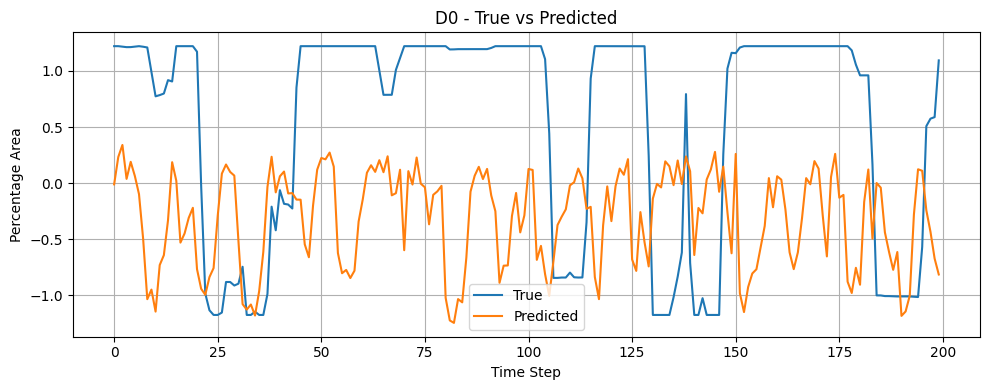

D1 - MAE: 1.2128, R²: -0.6720


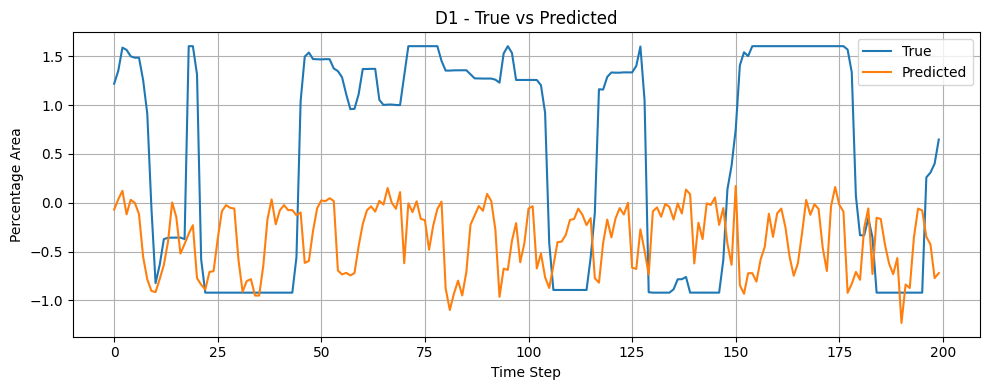

D2 - MAE: 1.0950, R²: -0.3689


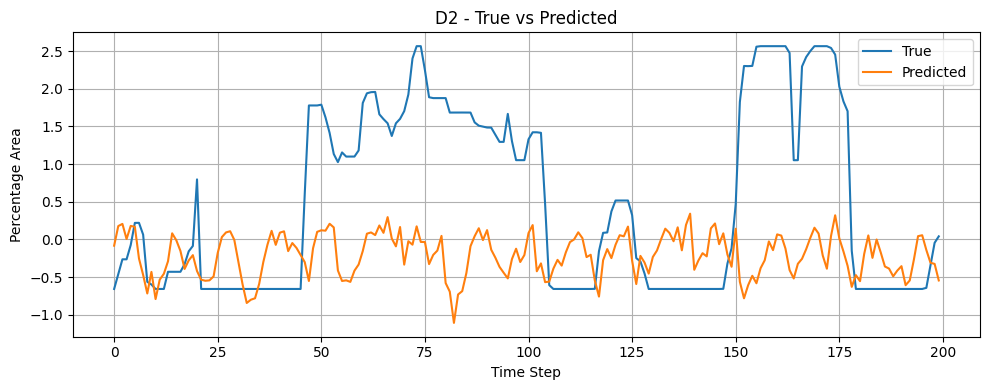

D3 - MAE: 0.7549, R²: -0.1943


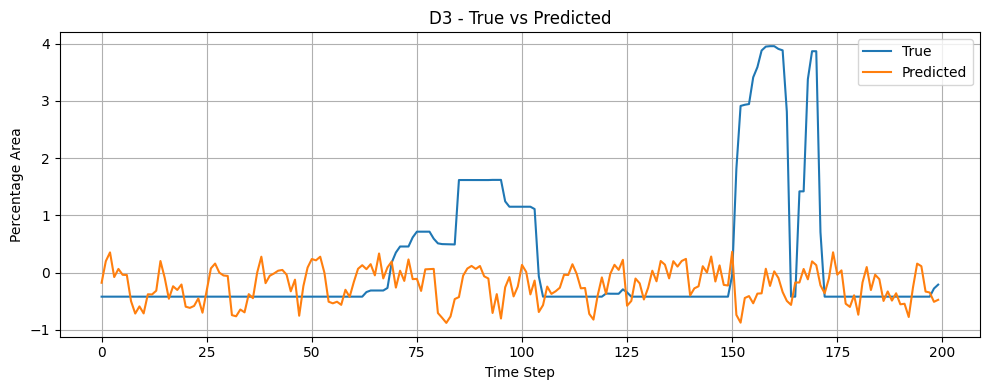

D4 - MAE: 0.5645, R²: -0.9849


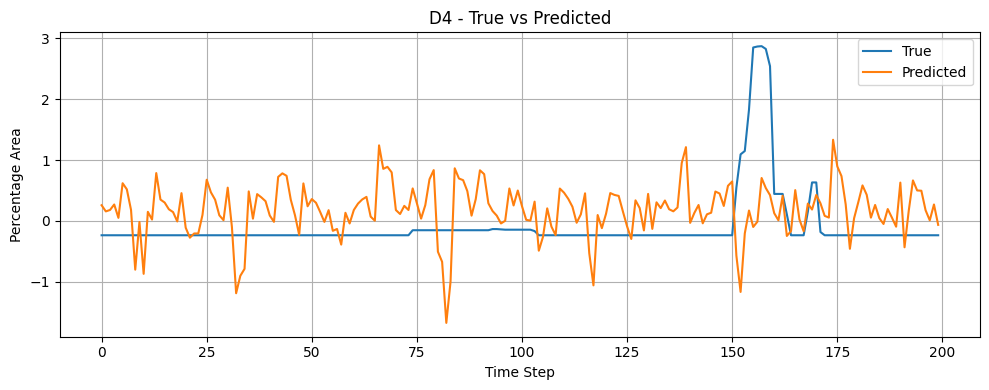

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization

# Load and clean your dataframe
# final_historical_df = pd.read_csv('your_data.csv')
final_historical_df = final_historical_df.dropna()

# Features (drop date + target drought levels)
X_raw = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])

# Targets (D0-D4)
y_raw = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']].values

# Scale features and targets
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X = X_scaler.fit_transform(X_raw)
y = y_scaler.fit_transform(y_raw)

# Train-test split (time-aware)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Define a more complex neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5)  # 5 outputs: D0, D1, D2, D3, D4
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.2, verbose=0)

# Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display overall MAE and R²
print(f"Overall MAE: {mae:.4f}")
print(f"Overall R²: {r2:.4f}")

# Evaluate per drought level
for i, level in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae_level = mean_absolute_error(y_true[:, i], y_pred[:, i])
    r2_level = r2_score(y_true[:, i], y_pred[:, i])
    print(f"{level} - MAE: {mae_level:.4f}, R²: {r2_level:.4f}")

    # Plot for each drought level
    plt.figure(figsize=(10, 4))
    plt.plot(y_true[:, i], label='True')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{level} - True vs Predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage Area")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# # Define multi-output neural network
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(16, activation='relu'),
#     Dense(5)  # 5 outputs: D0, D1, D2, D3, D4
# ])

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=32,
#                     validation_split=0.2, verbose=0)

# # Predict and inverse scale
# y_pred_scaled = model.predict(X_test)
# y_pred = y_scaler.inverse_transform(y_pred_scaled)
# y_true = y_scaler.inverse_transform(y_test)

# # Calculate evaluation metrics
# mae = mean_absolute_error(y_true, y_pred)
# r2 = r2_score(y_true, y_pred)

# # Display overall MAE and R²
# print(f"Overall MAE: {mae:.4f}")
# print(f"Overall R²: {r2:.4f}")

# # Evaluate per drought level
# for i, level in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
#     mae_level = mean_absolute_error(y_true[:, i], y_pred[:, i])
#     r2_level = r2_score(y_true[:, i], y_pred[:, i])
#     print(f"{level} - MAE: {mae_level:.4f}, R²: {r2_level:.4f}")

#     # Plot for each drought level
#     plt.figure(figsize=(10, 4))
#     plt.plot(y_true[:, i], label='True')
#     plt.plot(y_pred[:, i], label='Predicted')
#     plt.title(f"{level} - True vs Predicted")
#     plt.xlabel("Time Step")
#     plt.ylabel("Percentage Area")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.3537 - mae: 0.3856 - val_loss: 0.0503 - val_mae: 0.1576
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0482 - mae: 0.1416 - val_loss: 0.0610 - val_mae: 0.1702
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0443 - mae: 0.1308 - val_loss: 0.0374 - val_mae: 0.1315
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0388 - mae: 0.1230 - val_loss: 0.0356 - val_mae: 0.1276
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0369 - mae: 0.1213 - val_loss: 0.0412 - val_mae: 0.1360
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0324 - mae: 0.1093 - val_loss: 0.0521 - val_mae: 0.1502
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0338 - mae: 0.1109 - val_loss: 0.0410 - val_mae: 0.1479
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0387 - mae: 0.1280 - val_loss: 0.0652 - val_mae: 0.1785
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0371 - mae: 0.

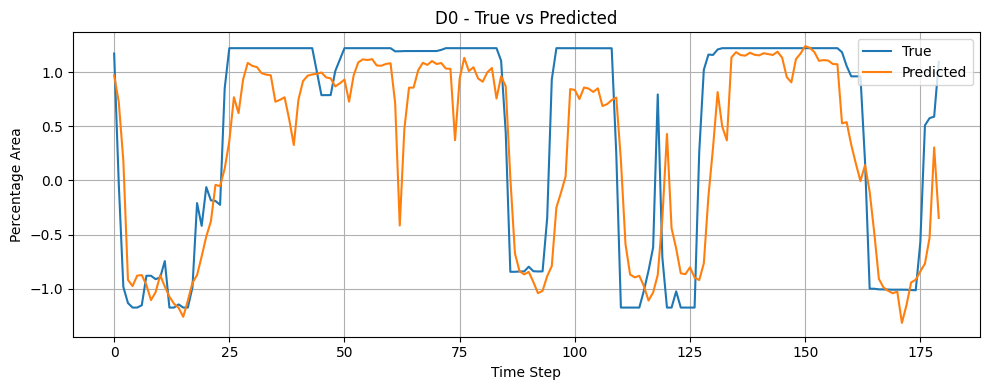

D1 - MAE: 0.3509, R²: 0.7893


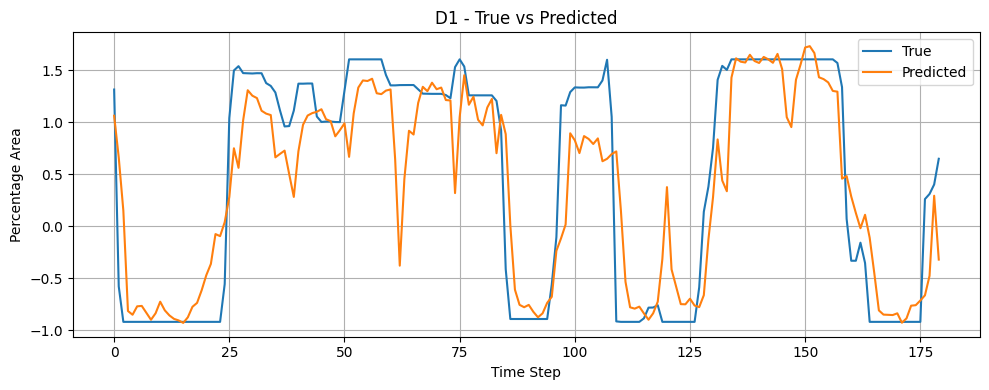

D2 - MAE: 0.4935, R²: 0.7055


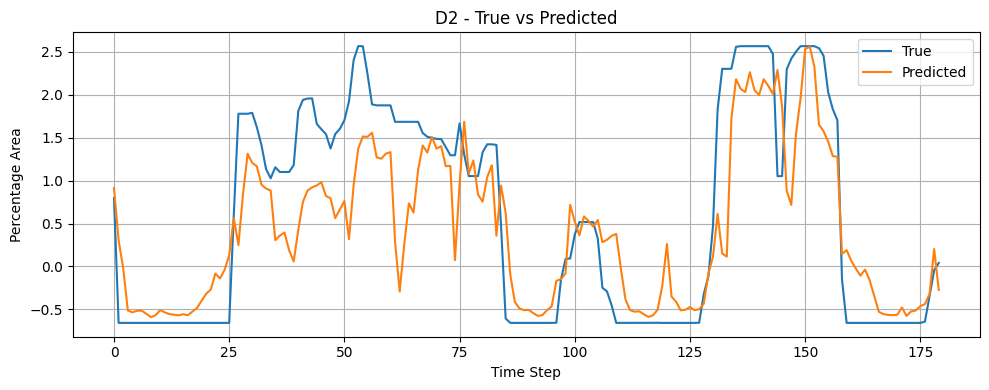

D3 - MAE: 0.6928, R²: 0.4245


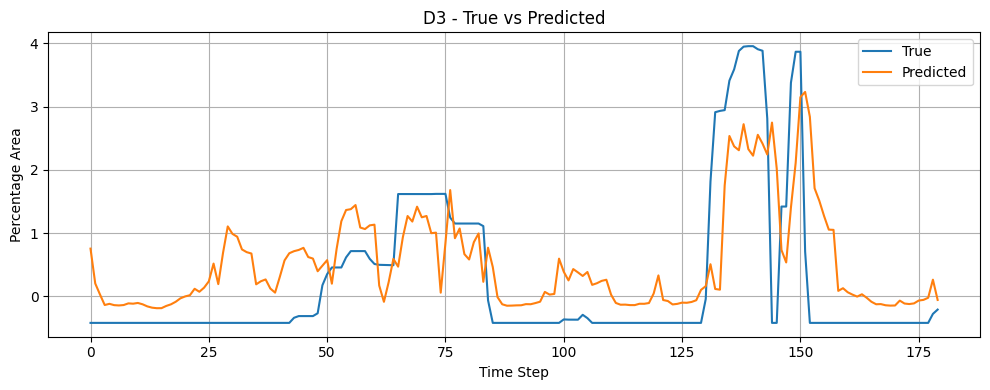

D4 - MAE: 0.5599, R²: -0.5456


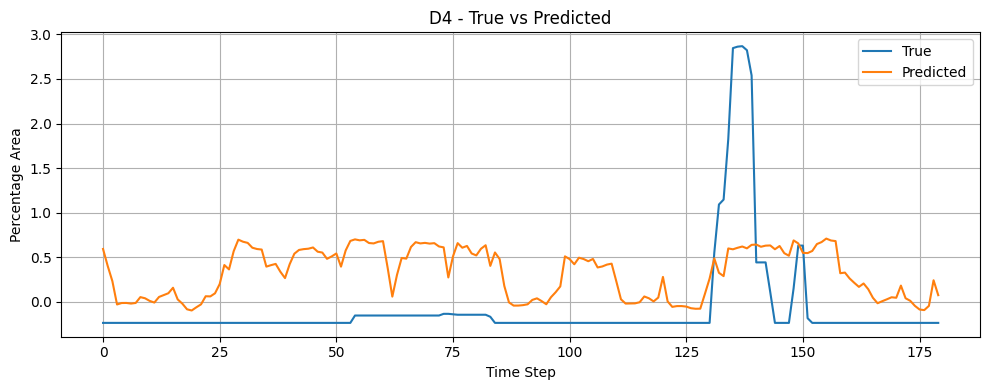

In [162]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Step 1: Preprocessing and Feature Engineering
# Assuming final_historical_df is your dataframe
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create Lag Features (1-step lag for D0, D1, D2, D3, D4)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):  # Lag 1, 2, 3
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)

# Create Rolling Mean and Std Features (using a window of 7 days, for example)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

# Drop NaN values generated by shifting and rolling operations
final_historical_df = final_historical_df.dropna()

# Step 2: Prepare Features and Targets
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize Features and Targets
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Step 3: Create Sequences for LSTM
SEQ_LENGTH = 12 # 12 time steps (e.g., 12 weeks of data)
# 12 = all r^2 are above 0 (d3,4 improved)


X_seq, y_seq = [], []
for i in range(len(X_scaled) - SEQ_LENGTH):
    X_seq.append(X_scaled[i:i+SEQ_LENGTH])  # Sequence of features
    y_seq.append(y_scaled[i+SEQ_LENGTH])  # Next time step prediction

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Step 4: Train/Test Split
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Step 5: Build and Train the LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(5)  # Output size matches D0, D1, D2, D3, D4
])

learning_rate = 0.05
# Compile the model with the custom learning rate
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Step 6: Evaluate the Model
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# Calculate MAE and R² for each drought level
from sklearn.metrics import mean_absolute_error, r2_score

for i, category in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
    mae = mean_absolute_error(y_test_orig[:, i], y_pred[:, i])
    r2 = r2_score(y_test_orig[:, i], y_pred[:, i])
    print(f"{category} - MAE: {mae:.4f}, R²: {r2:.4f}")
    
    # Plot predictions vs true values
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_orig[:, i], label='True')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f"{category} - True vs Predicted")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage Area")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0090 - mae: 0.0801 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0383 - val_loss: 0.0018 - val_mae: 0.0448
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0049 - mae: 0.0437 - val_loss: 0.0013 - val_mae: 0.0328
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - mae: 0.0443 - val_loss: 0.0013 - val_mae: 0.0262
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033 - mae: 0.0357 - val_loss: 0.0013 - val_mae: 0.0270
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0501 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0058 - mae: 0.0446 - val_loss: 0.0013 - val_mae: 0.0324
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0054 - mae: 0.0445 - val_loss: 0.0014 - val_mae: 0.0300
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
D4 - MAE: 0.3414, R²: 0.0399


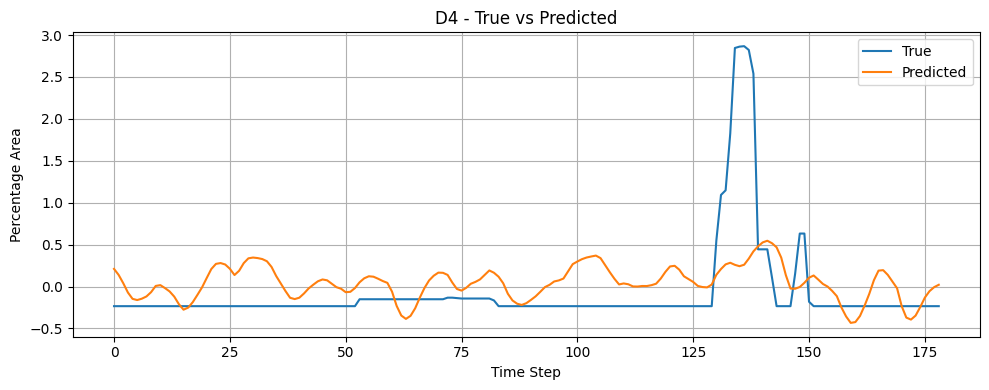

In [164]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt

# Assuming final_historical_df is your dataframe
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create Lag Features (1-step lag for D0, D1, D2, D3, D4)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):  # Lag 1, 2, 3
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)

# Create Rolling Mean and Std Features (using a window of 7 days, for example)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

# Drop NaN values generated by shifting and rolling operations
final_historical_df = final_historical_df.dropna()

# Prepare Features and Target specifically for D4
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D4']]

# Normalize Features and Target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Create Sequences for LSTM
SEQ_LENGTH = 12  # 12 months of data for time series forecasting

X_seq, y_seq = [], []
for i in range(len(X_scaled) - SEQ_LENGTH):
    X_seq.append(X_scaled[i:i+SEQ_LENGTH])  # Sequence of features
    y_seq.append(y_scaled[i+SEQ_LENGTH])  # Next time step prediction for D4

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train/Test Split
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build and Train the LSTM Model for D4
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(1)  # Output for D4 (single output regression task)
])

# Compile the model with Huber loss and Adam optimizer
model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the Model
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# Calculate MAE and R² for D4
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f"D4 - MAE: {mae:.4f}, R²: {r2:.4f}")

# Plot predictions vs true values for D4
plt.figure(figsize=(10, 4))
plt.plot(y_test_orig, label='True')
plt.plot(y_pred, label='Predicted')
plt.title("D4 - True vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Percentage Area")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0078 - mae: 0.0604 - val_loss: 0.0028 - val_mae: 0.0500
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0406 - val_loss: 0.0013 - val_mae: 0.0247
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - mae: 0.0377 - val_loss: 0.0014 - val_mae: 0.0288
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 - mae: 0.0459 - val_loss: 0.0013 - val_mae: 0.0309
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mae: 0.0383 - val_loss: 0.0014 - val_mae: 0.0286
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - mae: 0.0487 - val_loss: 0.0013 - val_mae: 0.0271
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0034 - mae: 0.0368 - val_loss: 0.0014 - val_mae: 0.0318
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
D4 - MAE: 0.2565, R²: 0.0822


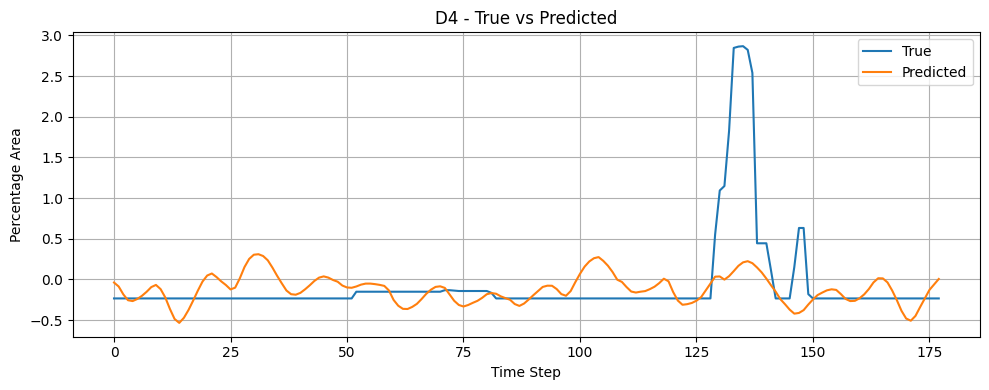

In [166]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt

# Assuming final_historical_df is your dataframe
final_historical_df['date'] = pd.to_datetime(final_historical_df['date'])

# Create Lag Features (1-step lag for D0, D1, D2, D3, D4)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):  # Lag 1, 2, 3
        final_historical_df[f'{col}_lag{lag}'] = final_historical_df[col].shift(lag)

# Create Rolling Mean and Std Features (using a window of 7 days, for example)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    final_historical_df[f'{col}_rolling_mean'] = final_historical_df[col].rolling(window=7).mean()
    final_historical_df[f'{col}_rolling_std'] = final_historical_df[col].rolling(window=7).std()

# Drop NaN values generated by shifting and rolling operations
final_historical_df = final_historical_df.dropna()

# Prepare Features and Target specifically for D4
features = final_historical_df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
target = final_historical_df[['D4']]

# Normalize Features and Target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(features)
y_scaled = target_scaler.fit_transform(target)

# Create Sequences for LSTM
SEQ_LENGTH = 12  # 12 months of data for time series forecasting

X_seq, y_seq = [], []
for i in range(len(X_scaled) - SEQ_LENGTH):
    X_seq.append(X_scaled[i:i+SEQ_LENGTH])  # Sequence of features
    y_seq.append(y_scaled[i+SEQ_LENGTH])  # Next time step prediction for D4

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train/Test Split
split_idx = int(0.8 * len(X_seq))  # 80% train, 20% test
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Build and Train the LSTM Model for D4
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(1)  # Output for D4 (single output regression task)
])

# Compile the model with Huber loss and Adam optimizer
model.compile(optimizer='adam', loss=Huber(), metrics=['mae'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=32,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Evaluate the Model
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and true labels to original scale
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# Calculate MAE and R² for D4
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)
print(f"D4 - MAE: {mae:.4f}, R²: {r2:.4f}")

# Plot predictions vs true values for D4
plt.figure(figsize=(10, 4))
plt.plot(y_test_orig, label='True')
plt.plot(y_pred, label='Predicted')
plt.title("D4 - True vs Predicted")
plt.xlabel("Time Step")
plt.ylabel("Percentage Area")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



====== RandomForest Results ======
D0 - MAE: 0.2078, R²: 0.8724


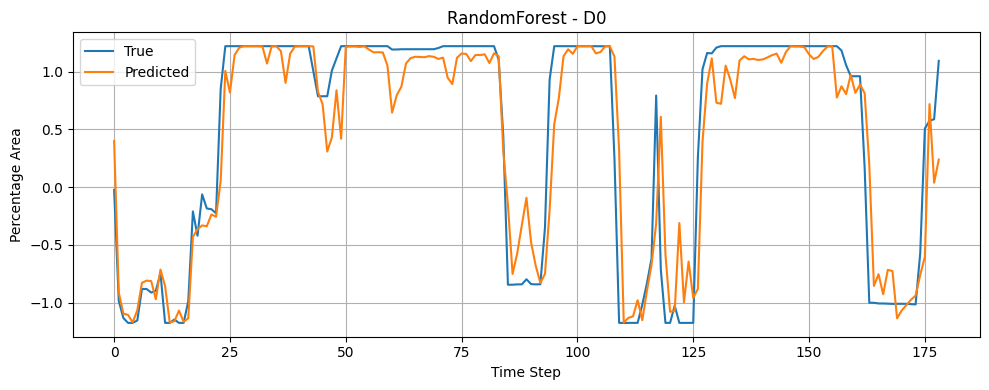

D1 - MAE: 0.2007, R²: 0.8965


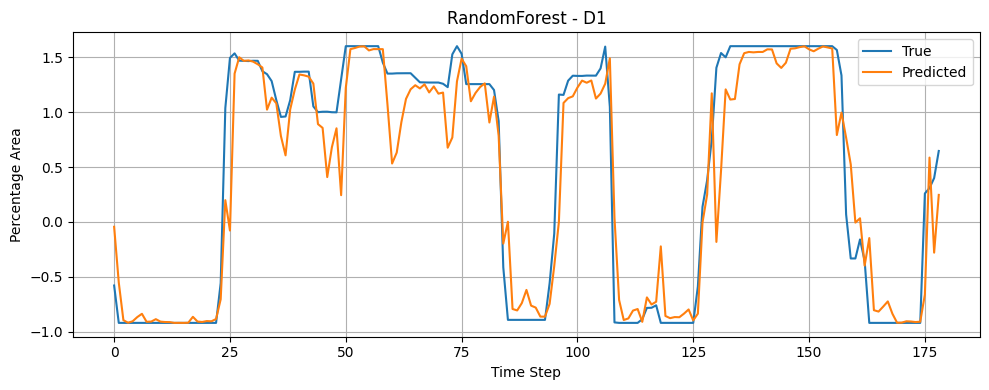

D2 - MAE: 0.2233, R²: 0.9008


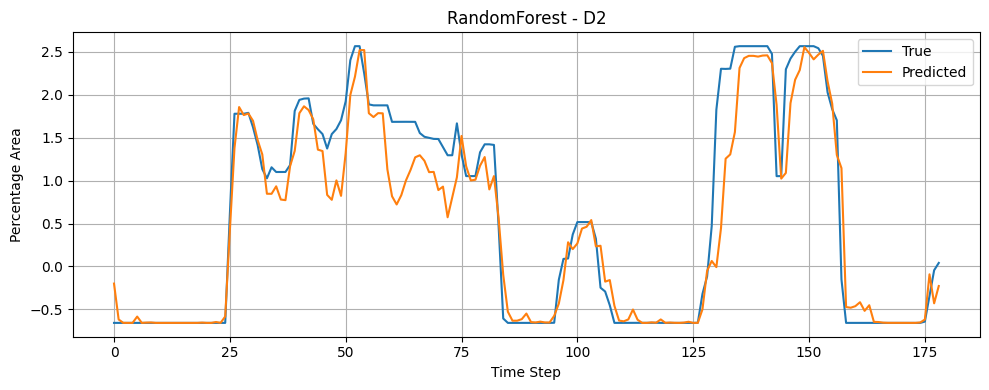

D3 - MAE: 0.2838, R²: 0.7271


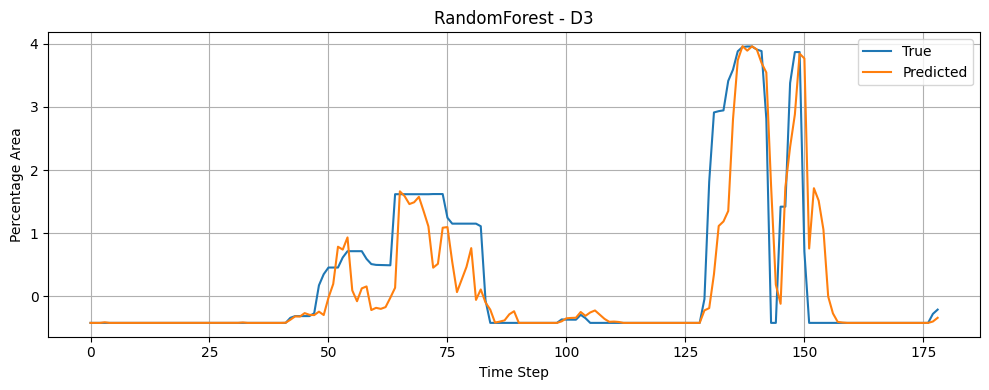

D4 - MAE: 0.1138, R²: 0.5707


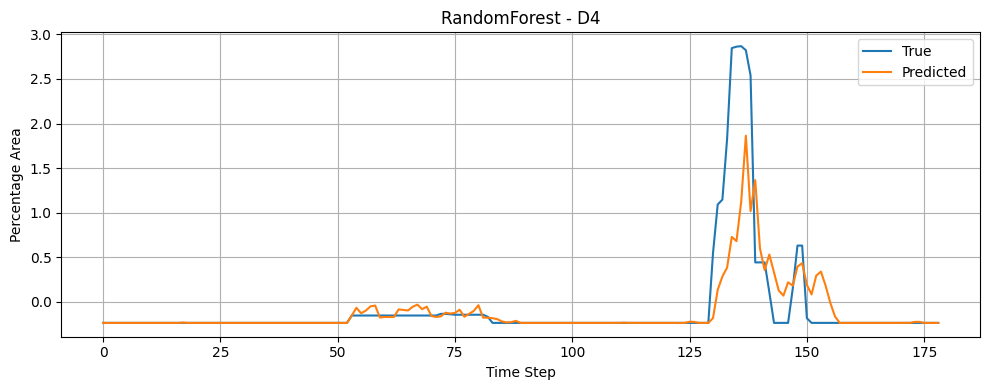


====== XGBoost Results ======
D0 - MAE: 0.2301, R²: 0.8547


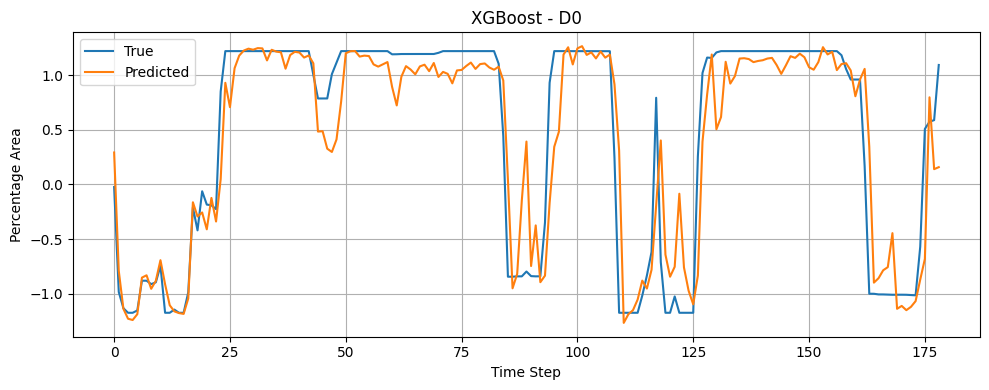

D1 - MAE: 0.2361, R²: 0.8679


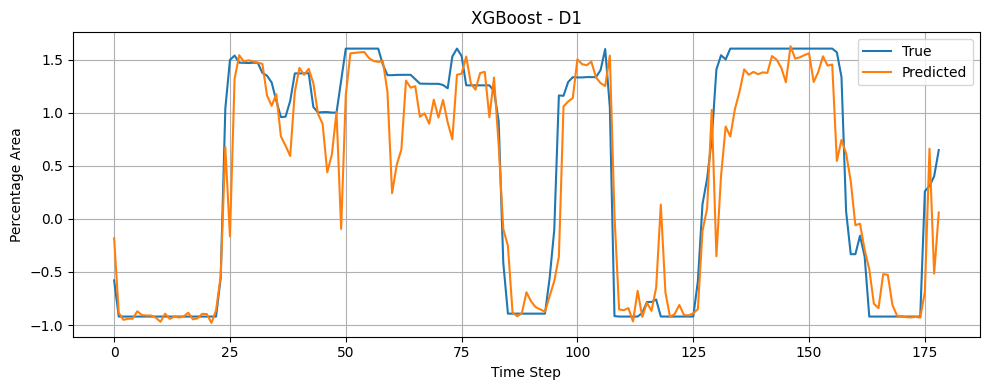

D2 - MAE: 0.2779, R²: 0.8397


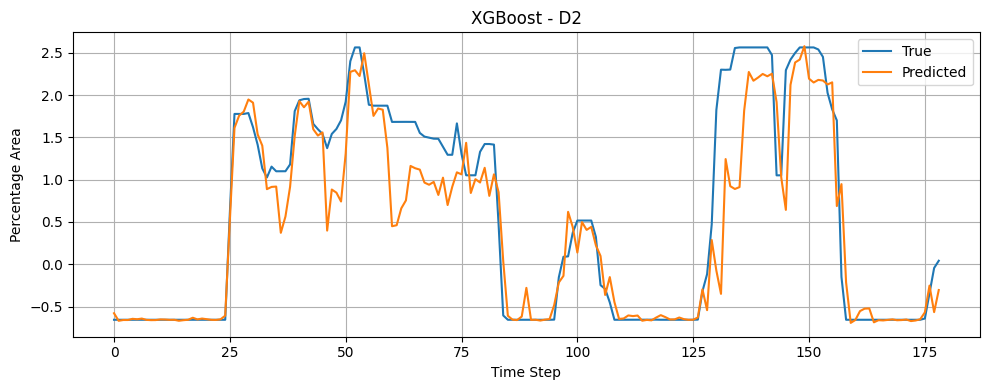

D3 - MAE: 0.3170, R²: 0.6558


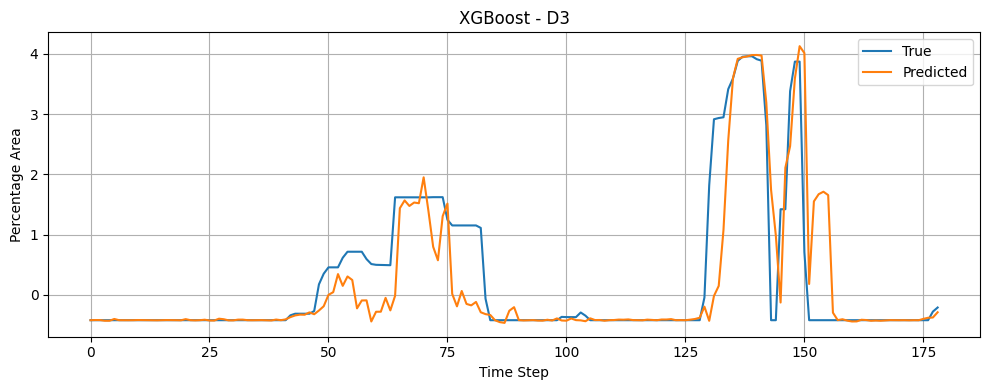

D4 - MAE: 0.1507, R²: 0.1483


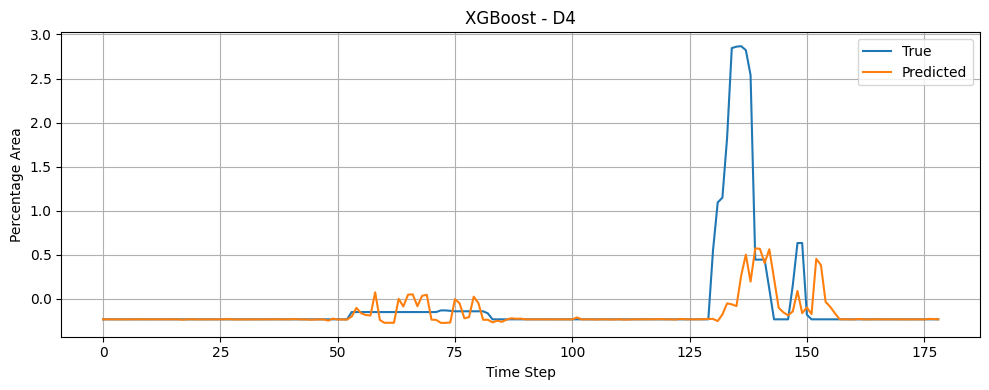

In [168]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Feature Engineering
df = final_historical_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Create lag features
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    for lag in range(1, 4):
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

# Create rolling stats (7-day window)
for col in ['D0', 'D1', 'D2', 'D3', 'D4']:
    df[f'{col}_roll_mean'] = df[col].rolling(window=7).mean()
    df[f'{col}_roll_std'] = df[col].rolling(window=7).std()

# Drop NaNs caused by lag and rolling
df = df.dropna().reset_index(drop=True)

# Step 2: Features and Targets
X = df.drop(columns=['date', 'D0', 'D1', 'D2', 'D3', 'D4'])
y = df[['D0', 'D1', 'D2', 'D3', 'D4']]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Time-aware split (80% train, 20% test)
split_idx = int(0.8 * len(X))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx].values, y[split_idx:].values

# Step 3: Fit and Evaluate Models
results = {}

for model_name, model_class in {
    'RandomForest': RandomForestRegressor,
    'XGBoost': XGBRegressor
}.items():
    
    print(f"\n====== {model_name} Results ======")
    model_results = {}
    
    for i, target in enumerate(['D0', 'D1', 'D2', 'D3', 'D4']):
        model = model_class(n_estimators=100, random_state=42)
        model.fit(X_train, y_train[:, i])
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test[:, i], y_pred)
        r2 = r2_score(y_test[:, i], y_pred)
        model_results[target] = {'MAE': mae, 'R2': r2}
        
        print(f"{target} - MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Plot predictions
        plt.figure(figsize=(10, 4))
        plt.plot(y_test[:, i], label='True')
        plt.plot(y_pred, label='Predicted')
        plt.title(f"{model_name} - {target}")
        plt.xlabel("Time Step")
        plt.ylabel("Percentage Area")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    results[model_name] = model_results
